In [24]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import ipywidgets as widgets
import os
# from pastamarkers import markers

# Retrieve data

We begin by fetching the reduced data using the Python script `data_transfer.py` from the file `df_merged.parquet`, then importing it into Pandas data frame.

In [25]:
df = pd.read_parquet('../scripts/df_after_upper_conds_2.parquet', engine='pyarrow')

In [26]:
df.head(2)

,objectId,candid,jd,mjd,fid,dc_flux,dc_sigflux,nr_flux,nr_sigflux,source,is_valid
0,ZTF17aaaeclk,1356301332615015001,2.459111e+06,59080,1,0.000286,0.000027,0.000286,0.000004,1,False
1,ZTF17aaaeclk,1356301332615015001,2.459111e+06,59080,2,0.000636,0.000062,0.000636,0.000012,1,False


In [27]:
df.shape

(1976622, 11)

Here we extract all unique IDs from our data frame:

In [28]:
unique_ids = df['objectId'].unique().tolist()
len(unique_ids)

31881

In [29]:
df.source.value_counts(normalize=True) * 100


source
0    58.942934
1    41.057066
Name: proportion, dtype: float64

In [50]:
 df.is_valid.value_counts(normalize=True) * 100 , (df.source.value_counts(normalize=True) * 100).values[1]


(is_valid
 True     59.483529
 False    40.516471
 Name: proportion, dtype: float64,
 41.057066045000006)

#

To calculate the weight values \(w_i\), we use the formula: `w_i` =\begin{cases}
\frac{1}{{\sigma_i^2}}, & \text{if data is available for day } i \\
0, & \text{otherwise}
\end{cases}

In [30]:
missing_data = (df['source'] == 0) | (df['dc_sigflux'] == 0)
df['dc_weight'] = np.where(missing_data, 0, 1 / (df['dc_sigflux'] ** 2))
df['nr_weight'] = np.where(missing_data, 0, 1 / (df['nr_sigflux'] ** 2))

In [31]:
df[['source','dc_weight']].head(3)

,source,dc_weight
0,1,1.353949e+09
1,1,2.615609e+08
2,0,0.000000e+00


# 

# 

# Percentenge of classes (classification) for all data 

In [32]:
# File path to unique IDs
ids_file_path = '../scripts/unique_ids.txt'

# Read the file and store each line as an element in a list
with open(ids_file_path, 'r') as file:
    IDS = file.read().splitlines()

# Initialize an empty list to store individual dataframes
dataframes = {}

# Folder name where the parquet files are located
folder_name = 'test_EB'#'test2'  

for Id in IDS:#[0:10]:
    file_name = f'{Id}.parquet'
    file_path = f'../scripts/{folder_name}/{file_name}'

    # Check if the file exists
    if os.path.exists(file_path):
        # Read the Parquet file into a DataFrame
        data = pd.read_parquet(file_path)
        
        # Append the dataframe to the list
        dataframes[Id] = data

dataframes

{'ZTF17aaaeclk':   classification  percentage  error_bar
 0           Star        69.6   0.022850
 1          RRLyr        19.0   0.019498
 2             **         9.4   0.014489
 3        Unknown         1.5   0.006003
 4           LPV*         0.5   0.003483,
 'ZTF17aaarimh':   classification  percentage  error_bar
 0           Star        68.0   0.020473
 1             **        29.7   0.020052
 2        Unknown         1.9   0.006034
 3              X         0.4   0.002720,
 'ZTF18acevrat':   classification  percentage  error_bar
 0       Orion_V*        54.7   0.051068
 1             **        41.1   0.050471
 2        Unknown         4.2   0.020605,
 'ZTF18abhxxas':   classification  percentage  error_bar
 0             **        97.6   0.006982
 1        Unknown         1.2   0.004968
 2           Star         0.4   0.002880
 3          RotV*         0.4   0.002880
 4             V*         0.2   0.002039
 5            EB*         0.2   0.002039,
 'ZTF18aakgeyw':   classificat

# 

# With distance - factor test 

We group the data by shared ID and create `NumPy` arrays for flux, weighted flux, and the source test(if it's a missing day(data)). We also determine the length of each time series.

In [33]:
grouped = df.groupby('objectId')

F = grouped['dc_flux'].apply(lambda x: x.values)#.values
sig = grouped['dc_sigflux'].apply(lambda x: x.values)#.values
W = grouped['dc_weight'].apply(lambda x: x.values)#.values
source = grouped['source'].apply(lambda x: x.values)#.values
lengths = grouped['source'].apply(lambda x: len(x))#.values
mjd = grouped['mjd'].apply(lambda x: x.values)#.values
is_valid = grouped['is_valid'].apply(lambda x: x.values)#.values


We define the length of our query,window or chunk, along with the limit factor and the size of each window or chunk.

In [38]:
m = 1
factor = 2*m+1 + 3*np.sqrt(2*(2*m+1))
chunk_size = 2 * (m + 1)

The `'no_match_test'` function evaluates whether there are any matches in the provided array, which contains the source test values for a window. If the sum of the array is less than or equal to 1, indicating that all values are missing or only one value is present, the function returns -99. Otherwise, it returns -1 to initialize the window's status as 'no match'.

In [39]:
def no_match_test(array):
    if array.sum() <= chunk_size-1 : 
        return -99 ## all are missing, or all except one
    return -1 # initialise as no match  # can be modifieted ? 

"`objects`" list contains a subset of the objects we intend to work with.

"`L_max`" is defined to facilitate partial iteration, serving as a debugging aid by allowing a limit to be set on the number of iterations performed.

We initialize the NumPy arrays with `None` values.

In [40]:
objects = unique_ids#[0:100]
num_objects = len(objects)

list_L_max = [110,3238,7862,7572,5701,3401,1801,297,70]
L_max = list_L_max[m]

print("L_max ", L_max)

R = np.empty(num_objects, dtype=object)
R_ref = np.empty(num_objects, dtype=object)
# Matches = np.empty(num_objects, dtype=object)
R_l = np.empty((num_objects, L_max), dtype=object)
num_by_obj = np.zeros((L_max,num_objects), dtype=object)
alp = np.empty((num_objects, L_max), dtype=object)
d = np.empty((num_objects, L_max), dtype=object)

L_max  3238


In [41]:
indexes_objects = range(num_objects)
Q = [None] * (L_max)
min_d =  [float('inf'), -1, -1] * (L_max)
num_left_by_Q = [0] * (L_max) ####### we don't need this one anymore <==> sum_i
selected_Q_K_i = np.empty(L_max, dtype=object)

We initialize R using the '`no_match_test`' function.

In [42]:
start_time = time.time()

n = lengths[objects[0]]
num_chunks = int(n // 2)-m 

for k in indexes_objects:
    
    chunks = np.array([source[objects[k]][i*2 : (i*2+chunk_size)] for i in range(num_chunks)])
    result = np.array(list(map(no_match_test, chunks)))
    R[k] = result.copy()
    R_ref[k] = result.copy()
    
    # for l in range(L_max):
    #     R_l[k][l] = result.copy()
    # a for loop isn't a good idea !!!! 

end_time = time.time()

# Compute the elapsed time
elapsed_time = end_time - start_time

print("Elapsed time:", elapsed_time/60, "minutes")

Elapsed time: 0.06461344957351685 minutes


In [43]:
indexes_array = np.array([np.where(array == -1)[0] for array in R], dtype=object)
rangek0 = [i for i in range(len(objects)) if len(indexes_array[i]) > 0]
len0 = len(rangek0)
len0

21394

In [44]:
indexes_array

array([array([12]), array([ 5,  9, 10, 16]), array([], dtype=int64), ...,
       array([ 6, 16]), array([ 1,  9, 16]), array([12])], dtype=object)

In [16]:
start_time = time.time()
classes0 = {}
for k in rangek0:
    df = dataframes[objects[k]]
    for index, row in df.iterrows():
        class_name = row['classification']
        percentage = row['percentage']
        error_bar = row['error_bar']
        if class_name in classes0:
            classes0[class_name][0] += percentage
            classes0[class_name][1] += error_bar**2
        else:
            classes0[class_name] = [percentage,error_bar**2]

    # classes.append(get_classification3(objects[k]))
for class_name, list1 in classes0.items():
    classes0[class_name][0] = round(list1[0] / len0 , 2)
sorted_classes0 = dict(sorted(classes0.items(), key=lambda item: item[1], reverse=True))

end_time = time.time()

print("Elapsed time:", (end_time - start_time)/60, "minutes")
sorted_classes0

Elapsed time: 0.0009400010108947754 minutes


{'Unknown': [38.82, 0.053751958533078445],
 'EB*': [24.67, 0.014448967521862088],
 'RRLyr': [6.43, 0.0018493916695441236],
 'Candidate_EB*': [6.23, 0.019478166895073343],
 'V*': [5.89, 0.00483374917765517],
 'QSO': [4.26, 0.0012256824457322173],
 'EB*_Candidate': [3.16, 0.017947841885728167],
 'CataclyV*': [1.49, 0.0007881905972772639],
 'BlueSG*': [0.91, 8.111392415184086e-05],
 'RedSG*': [0.88, 0.0004928423199084638],
 'Star': [0.69, 0.002732125668760201],
 'LPV*': [0.68, 0.0006953113546076551],
 'SN candidate': [0.65, 0.013690397951717753],
 'BLLac': [0.61, 0.00023344997879263174],
 'AGN_Candidate': [0.61, 0.000147744678298782],
 'Blue': [0.61, 0.00012120468370608137],
 'Candidate_RSG*': [0.49, 0.0013211355839840013],
 'PulsV*delSct': [0.31, 0.00011973669428114251],
 'PulsV*WVir': [0.3, 4.270289770298444e-05],
 'Irregular_V*': [0.3, 3.3212296287768686e-05],
 'RSG*_Candidate': [0.29, 0.0014283563472314608],
 'PulsV*': [0.29, 7.552530330000518e-05],
 'Radio': [0.27, 0.0087742203299850

In [23]:
import numpy as np

# List of all possible groups to merge
groups_to_merge = {
    'EB*': ['Candidate_EB*', 'EB*_Candidate'],
    # 'LPV*': ['Candidate_LP*', 'LP*_Candidate'],
    'RRLyr': ['Candidate_RRLyr', 'RRLyr_Candidate'],
    'CV*': ['Candidate_CV*', 'CV*_Candidate'],
    # 'WD*': ['Candidate_WD*', 'WD*_Candidate'],
    # 'YSO': ['Candidate_YSO', 'YSO_Candidate'],
    # 'C*': ['Candidate_C*', 'C*_Candidate'],
    'RSG*': ['Candidate_RSG*', 'RSG*_Candidate'],
    # 'TTau*': ['Candidate_TTau*', 'TTau*_Candidate'],
    # 'RGB*': [ 'RGB*_Candidate'],
}

# Initialize the new dictionary with the original data, excluding the ones to be merged
merged_data = {k: v for k, v in sorted_classes0.items() if k not in sum(groups_to_merge.values(), [])}

# Function to combine values and propagate errors
def combine_values_and_errors(keys):
    combined_value = sum(sorted_classes0[key][0] for key in keys)
    combined_error = np.sqrt(sum(sorted_classes0[key][1]**2 for key in keys))
    return [combined_value, combined_error]

# Merge the groups
for new_key, old_keys in groups_to_merge.items():
    if new_key in sorted_classes0:
        all_keys = [new_key] + old_keys
    else:
        all_keys = old_keys
    merged_data[new_key] = combine_values_and_errors(all_keys)

# Sort the merged data
sorted_classes0_m = dict(sorted(merged_data.items(), key=lambda item: item[1][0], reverse=True))

# Output the result
sorted_classes0_m 


{'Unknown': [38.82, 0.053751958533078445],
 'EB*': [34.06, 0.030171123220643525],
 'RRLyr': [6.67, 0.0019473100964148263],
 'V*': [5.89, 0.00483374917765517],
 'QSO': [4.26, 0.0012256824457322173],
 'CataclyV*': [1.49, 0.0007881905972772639],
 'BlueSG*': [0.91, 8.111392415184086e-05],
 'RedSG*': [0.88, 0.0004928423199084638],
 'RSG*': [0.78, 0.0019456621201907462],
 'Star': [0.69, 0.002732125668760201],
 'LPV*': [0.68, 0.0006953113546076551],
 'SN candidate': [0.65, 0.013690397951717753],
 'BLLac': [0.61, 0.00023344997879263174],
 'AGN_Candidate': [0.61, 0.000147744678298782],
 'Blue': [0.61, 0.00012120468370608137],
 'CV*': [0.37, 0.003105039892394288],
 'PulsV*delSct': [0.31, 0.00011973669428114251],
 'PulsV*WVir': [0.3, 4.270289770298444e-05],
 'Irregular_V*': [0.3, 3.3212296287768686e-05],
 'PulsV*': [0.29, 7.552530330000518e-05],
 'Radio': [0.27, 0.008774220329985035],
 'Microlensing candidate': [0.19, 0.010215212647149634],
 'EmObj': [0.1, 0.00044936380020898646],
 'Cl*': [0.06, 

### Loop to compute the distance of the subsequence in the time series to its nearest neighbor.

In [23]:
start_time = time.time()
rangek2 = list(range(len(objects)))

l= 0
while (l < L_max):
    indexes_array = np.array([np.where(array == -1)[0] for array in R], dtype=object)
    rangek2 = [i for i in range(len(objects)) if len(indexes_array[i]) > 0]

    has_empty_list = len(rangek2) == 0
    if has_empty_list:
        print("break , l = ", l )
        break
        
    num_left_by_Q[l] = len(rangek2)
        
    k = rangek2[0]
        
    f = F[objects[k]]
    index_no_match = indexes_array[k][0]
    k_Query_taked = k
    selected_Q_K_i[l] = [k,index_no_match]
    Q[l] = f[index_no_match*2 : index_no_match*2 +chunk_size]


    
    for k in rangek2:
        f = F[objects[k]]
        w = W[objects[k]]
        n = lengths[objects[k]]
        n_c = n - 2*m # (number of chunks x 2) ! it's (n/2 - m) but to optimize we mutiply by 2 directly !  
        #print(n, n_c,len(R[k]))



        s_1 = np.zeros(n_c, dtype=float)
        s_2 = np.zeros(n_c, dtype=float)
        
        for j in range(0,m+1): 
            h = np.tile(Q[l][j*2: j*2+2], (len(f[j*2:j*2+ n_c]) // 2, 1)).ravel() # array of h for r and g successive for the vectorisation

            s_1[:] += (f[j*2:j*2+ n_c]*h*w[j*2:j*2+ n_c])
            s_2[:] += (h**2 * w[j*2:j*2+ n_c])


        s_n = s_1[::2] + s_1[1::2]  
        s_d = s_2[::2] + s_2[1::2] 
        
        mask_no_0 = (s_d != 0)
        alp[k][l] = np.zeros_like(s_d, dtype=float)

        alp[k][l][mask_no_0] = s_n[mask_no_0] / s_d[mask_no_0] # # Perform division only where s_d(i) is not zero

        alpha = np.repeat(alp[k][l], 2) # duplicate alpha for each value (one for r and second for g)
     
    
        dd = np.zeros(n_c, dtype=float)
        
        for j in range(0,m+1):
            h = np.tile(Q[l][j*2: j*2+2], (len(f[j*2:j*2+ n_c]) // 2, 1)).ravel() # array of h for r and g successive for the vectorisation
            
            dd[:] += ((f[j*2:j*2+ n_c] - alpha[:] * h)**2) * w[j*2:j*2+ n_c] 
            #alpha[:n-j*2] ==> alpha[:]

        d[k][l] = dd[::2] + dd[1::2]
        
        factor_comparison =  d[k][l] <= factor
                
        R[k][indexes_array[k][factor_comparison[indexes_array[k]]]] = l # explanation follows below!
                
        R_l[k][l] = R_ref[k].copy()

        matches_k = float('inf')  # Start with a large number
        min_index = None  # Variable to store the index of the minimum value

        for i in range(len(factor_comparison)):
            if  R_l[k][l][i] != -99:
                if factor_comparison[i] :
                    R_l[k][l][i] = l
                    num_by_obj[l][k]+=1
                if index_no_match != i and d[k][l][i] < matches_k:
                        matches_k = d[k][l][i]  # Update the minimum value
                        min_index = i  #

        
        if matches_k < min_d[l * 3] :
            min_d[l * 3] = matches_k  # Instead of min_d[::3][l]
            min_d[l * 3 + 2] = min_index      # Instead of min_d[2::3][l]
            min_d[l * 3 + 1] = k            # Instead of min_d[1::3][l]

    R_l[k_Query_taked][l][index_no_match] = -2

 
    l += 1 
    
print("l = ",l)



end_time = time.time()

# Compute the elapsed time
elapsed_time += end_time - start_time

print("Elapsed time:", elapsed_time/60, "minutes")

l =  110
Elapsed time: 1.0163185834884643 minutes


Let's break down the expression `R[k][indexes_array[k][factor_comparison[indexes_array[k]]]] = l` step by step:

1. `indexes_array[k]`: This selects the array of indexes corresponding to the k-th element of `indexes_array`.
2. `factor_comparison[indexes_array[k]]`: This applies boolean indexing to `factor_comparison` using the indexes from `indexes_array[k]`. It selects only the elements of `factor_comparison` corresponding to the indexes in `indexes_array[k]`.
3. `indexes_array[k][factor_comparison[indexes_array[k]]]`: This gives the indices where the condition `factor_comparison` is true for the k-th element of `indexes_array`.
4. `R[k][indexes_array[k][factor_comparison[indexes_array[k]]]]`: This uses the indices obtained in the previous step to select elements from the k-th row of `R`.
5. `= l`: Finally, it assigns the value `l` to the selected elements of `R[k]`.


In [25]:
num_left_by_Q[-1]

1

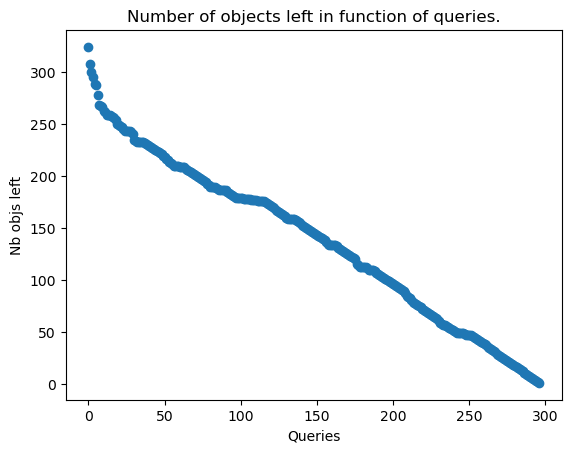

In [26]:
plt.scatter(range(L_max),num_left_by_Q)

plt.xlabel('Queries')
plt.ylabel('Nb objs left')
plt.title('Number of objects left in function of queries.')


# Create DataFrame
# data = {'Queries': range(L_max), 'Nb objs left': num_left_by_Q}
# df = pd.DataFrame(data)

# # Export to Excel
# df.to_csv('num_left_by_Q.csv', index=False)

# Show the plot
plt.show()


#


# 

In [ ]:
# import time
# import numpy as np

# # Assuming the variables d, Matrix_Matches, R_l, Q, length_no_missing, selected_Q_K_i are defined above

# start_time = time.time()

# # Save each variable in a different file using numpy.save or numpy.savez_compressed
# np.save('d.npy', d)  # For single array

In [ ]:
# np.save('Matrix_Matches.npy', Matrix_Matches)

In [ ]:
# np.save('R_l.npy', R_l)

In [ ]:
# np.save('Q.npy', Q)
# np.save('length_no_missing.npy', length_no_missing)
# np.save('selected_Q_K_i.npy', selected_Q_K_i)

# end_time = time.time()

# # Compute the elapsed time
# elapsed_time = end_time - start_time
# print("Elapsed time:", elapsed_time / 60, "minutes")

#


# 

### Calculate the Matrix of Matches (with windows represented in rows and queries as columns)

In [19]:
rangek = range(len(objects))

# Initialize list to hold transposed arrays for each k
Matrices_by_k = []

no_missing = np.zeros(len(rangek), dtype= object)
length_no_missing = np.zeros(len(rangek), dtype= int)

Reference_Table_list = []

In [20]:
start_time = time.time()
for k in rangek:
    no_missing[k] = np.where(R[k] != -99)[0]  
    
    length_no_missing[k] = len(no_missing[k])
    
    # Initialize transposed array
    Matrix= np.empty((length_no_missing[k], len(R_l[k])), dtype=object)
    
    refrence_table_k = np.empty(length_no_missing[k], dtype=object)
    
    # Transpose and store the arrays
    for i, idx in enumerate(no_missing[k]):
        for j, arr in enumerate(R_l[k]):
            if arr is not None:  # Check if arr is not None
                if arr[idx] == -2 or arr[idx] >= 0:
                    Matrix[i][j] = 1
                else:
                    Matrix[i][j] = 0
            else:
                Matrix[i][j] = 0
                #print(f"Error: arr is None at index {j} in R_l[{k}]")
            # if arr[idx] == -2 or arr[idx] >= 0:
            #     Matrix[i][j] = 1
            # else:
            #     Matrix[i][j] = 0
                
        refrence_table_k [i] =  [k ,idx]

                
    # Append transposed array to the list
    Matrices_by_k.append(Matrix)
    Reference_Table_list.append(refrence_table_k)

end_time = time.time()

# Compute the elapsed time
elapsed_time += end_time - start_time

print("Elapsed time:", elapsed_time/60, "minutes")
Matrices_by_k

Elapsed time: 0.5069718480110168 minutes


[array([], shape=(0, 297), dtype=object),
 array([], shape=(0, 297), dtype=object),
 array([], shape=(0, 297), dtype=object),
 array([], shape=(0, 297), dtype=object),
 array([], shape=(0, 297), dtype=object),
 array([], shape=(0, 297), dtype=object),
 array([], shape=(0, 297), dtype=object),
 array([], shape=(0, 297), dtype=object),
 array([], shape=(0, 297), dtype=object),
 array([], shape=(0, 297), dtype=object),
 array([], shape=(0, 297), dtype=object),
 array([], shape=(0, 297), dtype=object),
 array([], shape=(0, 297), dtype=object),
 array([], shape=(0, 297), dtype=object),
 array([], shape=(0, 297), dtype=object),
 array([], shape=(0, 297), dtype=object),
 array([], shape=(0, 297), dtype=object),
 array([], shape=(0, 297), dtype=object),
 array([], shape=(0, 297), dtype=object),
 array([], shape=(0, 297), dtype=object),
 array([], shape=(0, 297), dtype=object),
 array([], shape=(0, 297), dtype=object),
 array([], shape=(0, 297), dtype=object),
 array([], shape=(0, 297), dtype=o

In [21]:
Matrix_Matches = np.concatenate(Matrices_by_k, axis=0)
Reference_Table = np.concatenate(Reference_Table_list, axis=0)
Matrix_Matches

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 1]], dtype=object)

In [22]:
sum_j_rows = np.sum(Matrix_Matches, axis=1)
sum_j_rows


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [23]:
sum_i_columns = np.sum(Matrix_Matches, axis=0)
sum_i_columns

array([16, 11, 5, 7, 1, 9, 14, 1, 1, 4, 2, 3, 1, 1, 1, 1, 1, 2, 4, 1, 1,
       4, 2, 5, 1, 1, 1, 1, 2, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 3, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       5, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=o

#

#

In [24]:
def get_i_values_for_k(specific_k):
    return no_missing[specific_k]
get_i_values_for_k(0)  

array([], dtype=int64)

In [25]:
def get_k_i_for_row(global_idx):
    return Reference_Table[global_idx]
k,i = get_k_i_for_row(2)
k,i

(138, 2)

In [26]:
def get_i_indexes_for_k(specific_k):
    idx = 0 
    for k in rangek:
        if k == specific_k:
            return list(range(idx, idx + length_no_missing[k]))
        idx += length_no_missing[k]

get_i_indexes_for_k(0)

[]

#

# Matrix only for queries (len(Qs) x len(Qs))

In [ ]:
Matrix_Queries = []

for k,i in selected_Q_K_i:#[:5]:
    #print(get_i_values_for_k(k),i)
    i_k = np.where(get_i_values_for_k(k) == i)[0][0]
    #print(get_i_indexes_for_k(k),i_k)
    global_idx = get_i_indexes_for_k(k)[i_k]
    Matrix_Queries.append(Matrix_Matches[global_idx])

    #[0][0]
Matrix_Queries

In [ ]:
len(Matrix_Queries)

In [ ]:
sum_j_rows_queries = np.sum(Matrix_Queries, axis=1)

sum_i_columns_queries = np.sum(Matrix_Queries, axis=0)
sum_i_columns_queries,sum_j_rows_queries

In [ ]:
sum_i_columns_queries.argmax(),sum_i_columns_queries.max()

In [ ]:
sum_j_rows_queries.argmax(), sum_j_rows_queries.max()

In [ ]:
sum_j_rows_queries.sum(), sum_i_columns_queries.sum()

#

#

In [ ]:
total_matches = sum(sum_i_columns) + sum(sum_j_rows)

I_i_j = Matrix_Matches[:].copy() #*(sum_i[:])
I_i_j


In [ ]:
for j, sj in enumerate(sum_j_rows):
    for i, si in enumerate(sum_i_columns):
        dn = (si*sj)
        if dn == 0:
            I_i_j[j][i] *= np.inf # we don't need this anymore , No, we do , if l_max != len(Q)
        else:
            I_i_j[j][i] *= total_matches/ dn
I_i_j

In [ ]:
# nonzero_indices = np.nonzero(np.outer(sum_j, sum_i))

# # Update only non-zero elements
# I_i_j[nonzero_indices] = I_i_j[nonzero_indices] / (sum_i[nonzero_indices[1]] * sum_j[nonzero_indices[0]])

# #I_i_j[I_i_j == 0] = np.inf


#

###### Compute the query with the highest number of matches and the one with the fewest matches.

In [ ]:
max(sum_i_columns),min(sum_i_columns), np.argmax(sum_i_columns), np.argmin(sum_i_columns), selected_Q_K_i[94], selected_Q_K_i[100]

###### Compute the window with the highest number of matches on queries and the one with the fewest matches.

In [ ]:
#flattened_array = np.concatenate([arr.flatten() for arr in sum_j])
maximum_value = np.max(sum_j_rows)
maximum_value, np.argmax(sum_j_rows),sum_j_rows[155]

In [ ]:
# Find indices of non-zero values
non_zero_indices = np.argwhere(sum_j_rows != 0).flatten()

# Retrieve non-zero values
non_zero_values = sum_j_rows[non_zero_indices]

# Find the index of the minimum non-zero value
min_non_zero_index = non_zero_indices[np.argmin(non_zero_values)]

min_non_zero_value = sum_j_rows[min_non_zero_index]

min_non_zero_value, min_non_zero_index

# 

### Function to detect a specific window in a time series (specified by its object and index within this object).

In [27]:
def if_a_query(k_TS, i_TS, selected_Q_K_i):
    mask = selected_Q_K_i != None
    for index_Q, (k, i) in enumerate(selected_Q_K_i[mask]):
        if k_TS == k and i_TS == i:
            return True, index_Q, f"This window is used as the {index_Q}th query! "
    return False, 0 , "This window is not used as a query ! "

In [28]:
def get_m(i,j):
    return concatenated_array[j][i] ### I need to check this 2 j,i or i,j

def get_i_by_sum(i):
        return sum_i_columns[i]

def get_j_by_sum(j):
        return sum_i_columns[j]

    
def get_k_i_of_Q(l):
    return selected_Q_K_i[l]


#

#

#

#

#

## Functions to compute the numbers of matches and plot the results 

#### these functions should be in another file

In [29]:
def plot_distance_flux(k,l,open_Fink= False):
    print("\n______________________________________________________________________________________________")
    print(f"{objects[k]}")
    #get_classification(objects[k])

    for index, row in dataframes[objects[k]].iterrows():
        classification = row['classification']
        percentage = row['percentage']
        error_bar = row['error_bar']
        print(f"                        {classification} : {percentage:.1f}% ") 
   
    
#     for class_name, percentage in dict_classes.items():
#         print(f"                        {class_name} : {percentage:.1f}%") 
    import ipywidgets as widgets
          
    button = widgets.Button(description=f"open in FINK")
    # Capture current values of kk and l in lambda's default arguments
    button.on_click(lambda _, k=k : on_button_clicked_plot(objects[k]))
    display(button)

    
    plt.figure(figsize=(14, 12))

    # Plot for F[k]
    plt.subplot(2, 1, 1)

    for i in range(int(len(F[objects[k]])/2)):
        if source.loc[objects[k]][2*i] == 0:
            marker = 'x'
            plt.errorbar(mjd.loc[objects[k]][2*i], F.loc[objects[k]][2*i], 
                     #sig[objects[k]][2*i]*0.4,
                     c='C0', marker='x')
        else:
            if is_valid[objects[k]][2*i] == True:
                marker = 'o'
            elif is_valid[objects[k]][2*i] == False :
                marker = '.'
                
            plt.errorbar(mjd.loc[objects[k]][2*i], F.loc[objects[k]][2*i], 
                     sig.loc[objects[k]][2*i],
                     c='C0', marker=marker)

        if source.loc[objects[k]][2*i+1] == 0:
            marker = 'x'
            plt.errorbar(mjd.loc[objects[k]][2*i+1], F.loc[objects[k]][2*i+1],
                     #sig[objects[k]][2*i+1]*0.4,
                     c='C1', marker='x')
            
        else:
            if is_valid[objects[k]][2*i+1] == True:
                marker = 'o'
            elif is_valid[objects[k]][2*i+1] == False :
                marker = '.'
                
            plt.errorbar(mjd.loc[objects[k]][2*i+1], F.loc[objects[k]][2*i+1],
                     sig.loc[objects[k]][2*i+1],
                     c='C1', marker=marker)
            
        a_query,l_1, string = if_a_query(k,i,selected_Q_K_i)
            
        if a_query and l_1 == l:
            print(string)
            
            # Define the window of indices
            window_start = mjd.loc[objects[k]][2*i]  # Index of the window start
            window_end = mjd.loc[objects[k]][2*i] + int(len(Q[l])/2 - 1)  # Index of the window end
            
            
            # Create an array of float indices
            indices = np.arange(window_start, window_end + 1)
            indices = np.concatenate(([indices[0] - 0.5], indices, [indices[-1] + 0.5]))

            # Plot a shaded region for the window
            plt.fill_between(indices, min(Q[l])/1.9, max(Q[l])*1.2, color='gray', alpha=0.2)
            
        
    plt.plot([], [], color='C1', marker='x', label='missing points !')
    plt.plot([], [], color='C0', marker='o', label='origin')
    plt.plot([], [], color='C0', marker='x', label='missing points !')
    plt.plot([], [], color='C1', marker='o', label='origin')
    
   
    ################################### what about the seccond window !? 
    moy_alp = 1+0*alp[k][l].mean()
    #moy_alp = np.median(F[k])/np.median(Q[l]) #Manu test

    plt.plot(mjd.loc[objects[k]][::2], F.loc[objects[k]][::2], c='C0', linewidth = 1)
    plt.plot(mjd.loc[objects[k]][1::2], F.loc[objects[k]][1::2], c='C1', linewidth = 1)

    plt.plot(np.arange(len(Q[l]) // 2) - 1-m + mjd.loc[objects[k]][0], Q[l][::2]*moy_alp, c='g', label='Q[l]',marker='.', linewidth=3, zorder=3)
    plt.plot(np.arange(len(Q[l]) // 2) - 1-m + mjd.loc[objects[k]][0], Q[l][1::2]*moy_alp, c='r', label='Q[l]',marker='.', linewidth=3, zorder=3)

    # Define the window of indices
    window_start = -1-m + mjd.loc[objects[k]][0] # Index of the window start
    window_end = int(len(Q[l])/2 - 1-1 -m)+ mjd.loc[objects[k]][0]  # Index of the window end

    # Create an array of float indices
    indices = np.arange(window_start, window_end + 1)
    indices = np.concatenate(([indices[0] - 0.4], indices, [indices[-1] + 0.4]))

    # Plot a shaded region for the window
    plt.fill_between(indices, min(Q[l])/1.2*moy_alp, max(Q[l])*1.2*moy_alp, color='gray', alpha=0.2)

    # plt.xlabel('Index')
    plt.ylabel('Flux')
    # plt.title('Flux Plot')
    plt.legend()
    




#     ###############                       Plot for d[k][0]                       ###############

    plt.subplot(2, 1, 2)
    plt.plot([-1-m, -1-m], [0, 0], color='none')  # Plot an empty line with zero length
    plt.plot(range(len(d[k][l])), d[k][l],color='C0', linestyle='-',linewidth=1)
    
#     matches = all_matches[k]#Matches[k]#
#     for i, match_count in enumerate(matches):
#         plt.text(i+0.2, d[k][l][i]+d[k][l][i]*5/100, str(match_count), fontsize=10, color='red', ha='left')
    matches_idx = get_i_indexes_for_k(k)
    matches2 = sum_j_rows[matches_idx]

    # Plot dummy points with desired colors and markers
    plt.plot([], [], color='black', marker='o', label='Query chosed')#markers.soli
    plt.plot([], [], color='red', marker='x', label='missing cases !')
    plt.plot([], [], color='blue', marker='s', label='Matched here')#markers.ravioli
    plt.plot([], [], color='green', marker='*', label='Matches with a different `l` (Query)')#markers.stelline
    plt.plot([], [], color='yellow', marker='^', label=f'Not matched with any of the {L_max} options we selected') #markers.tortellini
    
    c= 0
    
    for i, val in enumerate(R_l[k][l]):
            if val == -99:
                plt.scatter(i, d[k][l][i], color='red', marker='x', s=50)  # marker size 50
                plt.text(i+0.2, d[k][l][i]+d[k][l][i]*5/100, 0, fontsize=10, color='red', ha='left')
                c+=1
#                 plt.text(i+0.2, d[k][l][i]+d[k][l][i]*5/100, 0*str(matches2[i]), fontsize=10, color='red', ha='left')

            elif val == l:
                plt.scatter(i, d[k][l][i], color='blue', marker='s', s=50)
                plt.text(i+0.2, d[k][l][i]+d[k][l][i]*5/100, str(matches2[i-c]), fontsize=10, color='blue', ha='left')

            elif val == -2:
                plt.scatter(i, d[k][l][i], color='black', marker='o', s=50) 
                plt.text(i+0.2, d[k][l][i]+d[k][l][i]*5/100, str(matches2[i-c]), fontsize=10, color='black', ha='left')

            elif matches2[i-c]==0:
                plt.scatter(i, d[k][l][i], color='yellow', marker='^', s=50) 
                plt.text(i+0.2, d[k][l][i]+d[k][l][i]*5/100, str(matches2[i-c]), fontsize=10, color='yellow', ha='left')

            else:
                plt.scatter(i, d[k][l][i], color='green', marker='*', s=75)
                plt.text(i+0.2, d[k][l][i]+d[k][l][i]*5/100, str(matches2[i-c]), fontsize=10, color='green', ha='left')




    plt.legend(fontsize=8) 
    #plt.legend(loc='upper right', fontsize=8)

    plt.ylabel('distance')



    ###############                       Plot for alpha[k][l]                       ###############

#     plt.subplot(3, 1, 3)
#     plt.plot(range(len(alp[k][l])), alp[k][l], marker='.', linestyle='-',color='black')
#     plt.xlabel('Index')
#     plt.ylabel('Value')
#     plt.title('alpha Plot')




    plt.subplots_adjust(top=0.93)  # Adjust the top margin for the super title
    plt.suptitle(f"{objects[k]}, k = {k}, l = {l} ", fontname='Arial', fontsize=16, fontweight='bold')
    plt.show()
    

    if open_Fink:
        open_website(objects[k])


import webbrowser

def open_website(k):
    website_url = f'https://fink-portal.org/{k}'
    webbrowser.open(website_url)

def on_button_clicked_plot(Id):
    print("URL opened")
    open_website(Id)


In [30]:
# plot_distance_flux(0,0)

In [31]:
def plot_distance_flux_min(k,l,min_d_i):
    print("\n______________________________________________________________________________________________")
    print(f"{objects[k]}")
    
    #get_classification(objects[k])

    for index, row in dataframes[objects[k]].iterrows():
        classification = row['classification']
        percentage = row['percentage']
        error_bar = row['error_bar']
        print(f"                        {classification} : {percentage:.1f}% ") 
   
    
    import ipywidgets as widgets
          
    button = widgets.Button(description=f"open in FINK")
    # Capture current values of kk and l in lambda's default arguments
    button.on_click(lambda _, k=k : on_button_clicked_plot(objects[k]))
    display(button)

    
    plt.figure(figsize=(14, 12))

    # Plot for F[k]
    plt.subplot(2, 1, 1)

    for i in range(int(len(F[objects[k]])/2)):
        if source.loc[objects[k]][2*i] == 0:
            marker = 'x'
            plt.errorbar(mjd.loc[objects[k]][2*i], F.loc[objects[k]][2*i], 
                     #sig[objects[k]][2*i]*0.4,
                     c='C0', marker='x')
        else:
            if is_valid[objects[k]][2*i] == True:
                marker = 'o'
            elif is_valid[objects[k]][2*i] == False :
                marker = '.'
                
            plt.errorbar(mjd.loc[objects[k]][2*i], F.loc[objects[k]][2*i], 
                     sig.loc[objects[k]][2*i],
                     c='C0', marker=marker)

        if source.loc[objects[k]][2*i+1] == 0:
            marker = 'x'
            plt.errorbar(mjd.loc[objects[k]][2*i+1], F.loc[objects[k]][2*i+1],
                     #sig[objects[k]][2*i+1]*0.4,
                     c='C1', marker='x')
            
        else:
            if is_valid[objects[k]][2*i+1] == True:
                marker = 'o'
            elif is_valid[objects[k]][2*i+1] == False :
                marker = '.'
                
            plt.errorbar(mjd.loc[objects[k]][2*i+1], F.loc[objects[k]][2*i+1],
                     sig.loc[objects[k]][2*i+1],
                     c='C1', marker=marker)
            
        # a_query,l_1, string = if_a_query(k,i,selected_Q_K_i)
            
        # if a_query and l_1 == l:
        #     print(string)
            
            # Define the window of indices
    window_start = mjd.loc[objects[k]][2*min_d_i]  # Index of the window start
    window_end = mjd.loc[objects[k]][2*min_d_i] + int(m)  # Index of the window end
    
    
    # Create an array of float indices
    indices = np.arange(window_start, window_end + 1)
    indices = np.concatenate(([indices[0] - 0.5], indices, [indices[-1] + 0.5]))

    # Plot a shaded region for the window
    plt.fill_between(indices, min(F[objects[k]])/1.9, max(F[objects[k]])*1.2, color='gray', alpha=0.2)
        
    
    plt.plot([], [], color='C1', marker='x', label='missing points !')
    plt.plot([], [], color='C0', marker='o', label='origin')
    plt.plot([], [], color='C0', marker='x', label='missing points !')
    plt.plot([], [], color='C1', marker='o', label='origin')
    
   
    ################################### what about the seccond window !? 
    moy_alp = 1#+0*alp[k][l].mean()
    #moy_alp = np.median(F[k])/np.median(Q[l]) #Manu test

    plt.plot(mjd.loc[objects[k]][::2], F.loc[objects[k]][::2], c='C0', linewidth = 1)
    plt.plot(mjd.loc[objects[k]][1::2], F.loc[objects[k]][1::2], c='C1', linewidth = 1)

    plt.plot(np.arange(len(Q[l]) // 2) - 1-m + mjd.loc[objects[k]][0], Q[l][::2]*moy_alp, c='g', label='Q[l]',marker='.', linewidth=3, zorder=3)
    plt.plot(np.arange(len(Q[l]) // 2) - 1-m + mjd.loc[objects[k]][0], Q[l][1::2]*moy_alp, c='r', label='Q[l]',marker='.', linewidth=3, zorder=3)

    # Define the window of indices
    window_start = -1-m + mjd.loc[objects[k]][0] # Index of the window start
    window_end = int(len(Q[l])/2 - 1-1 -m)+ mjd.loc[objects[k]][0]  # Index of the window end

    # Create an array of float indices
    indices = np.arange(window_start, window_end + 1)
    indices = np.concatenate(([indices[0] - 0.4], indices, [indices[-1] + 0.4]))

    # Plot a shaded region for the window
    plt.fill_between(indices, min(Q[l])/1.2*moy_alp, max(Q[l])*1.2*moy_alp, color='gray', alpha=0.2)

    # plt.xlabel('Index')
    plt.ylabel('Flux')
    # plt.title('Flux Plot')
    plt.legend()

    
    plt.subplots_adjust(top=0.93)  # Adjust the top margin for the super title
    plt.suptitle(f"{objects[k]}, k = {k}, l = {l} ", fontname='Arial', fontsize=16, fontweight='bold')
    plt.show()
    


def on_button_clicked_plot(Id):
    print("URL opened")
    open_website(Id)


# 



# 



# Nearest query : 


In [32]:
nearst_query = {}
dis = []
for l, list_l in enumerate(selected_Q_K_i):
    #print(l, list)
    k,i = list_l
    
    nearst_query[l] = [-1,float('inf')]
    for l_after, list_after in enumerate(selected_Q_K_i[l+1:]):
        l_after += l+1
        # print(l, list,l_after, list_after)
        k_after, i_after = list_after
        if k_after != k :
            distance = d[k_after][l][i_after]
            # print(distance)
            if nearst_query[l][1] > distance :
                nearst_query[l] = [l_after,distance]
            
    for l_before, list_before in enumerate(selected_Q_K_i[:l]):
        # l_after += l+1
        # print(l, list,l_after, list_after)
        k_before, i_before = list_before
        if k_before != k :
    
            distance = d[k][l_before][i]
            # print(distance)
            if nearst_query[l][1] > distance :
                nearst_query[l] = [l_before,distance] 
    
    dis.append(nearst_query[l][1])

nearst_query

{0: [4, 83.12420373350824],
 1: [4, 81.2836672855666],
 2: [200, 55.710425614991784],
 3: [4, 57.91039986816898],
 4: [3, 57.91039986816898],
 5: [21, 60.971422444746764],
 6: [7, 77.86247276033292],
 7: [6, 77.86247276033292],
 8: [150, 137.79799658601394],
 9: [156, 122.09379996005194],
 10: [117, 61.54045948486657],
 11: [150, 138.63015332262648],
 12: [288, 143.83362530668484],
 13: [288, 117.51636148042135],
 14: [17, 94.39835035270167],
 15: [288, 120.25333019727573],
 16: [148, 189.8444958321552],
 17: [14, 94.39835035270167],
 18: [216, 86.88324256069379],
 19: [156, 42.61328443138217],
 20: [5, 79.10368540367251],
 21: [117, 56.20219049654022],
 22: [150, 107.21586353399093],
 23: [165, 113.06424334398386],
 24: [156, 99.32199416652051],
 25: [150, 116.85709451026102],
 26: [150, 60.24938108739747],
 27: [150, 122.06814439001427],
 28: [150, 118.54038060246614],
 29: [159, 87.28714559615592],
 30: [150, 131.22420374618514],
 31: [271, 89.97744030592183],
 32: [271, 40.46041722


# 



# Nearst window(with only one match) to each query 



In [33]:
nearst_window_1 = {}
dis = [0]*L_max
for l, list_l in enumerate(selected_Q_K_i):
    # print(l, list_l)
    k,i = list_l
    
    nearst_window_1[l] = [-1,-1,float('inf')],[-1,-1,float('inf')],[-1,-1,float('inf')]
    # wind_l = list_l #get_k_i_of_Q(l)
    
    index = Reference_Table.tolist().index(list_l)#Reference_Table_list.index(wind_l)

    # print(l,"\n")
    
    for row, list_w in enumerate(Reference_Table[index+1:]):
        row += index +1
        k_window, i_window = list_w
        
        if sum_j_rows[row] == 1 and R[k_window][i_window] > l : 
            # print(index, row+index)
            # print(k_window, i_window)

            distance = d[k_window][l][i_window]
            # print(distance)

            if nearst_window_1[l][0][2] > distance :
                distance3 = nearst_window_1[l][1][2]
                distance2 = nearst_window_1[l][0][2]
                k_window3 = nearst_window_1[l][1][0]
                k_window2 = nearst_window_1[l][0][0]
                i_window3 = nearst_window_1[l][1][1]
                i_window2 = nearst_window_1[l][0][1]
                nearst_window_1[l] = ([k_window, i_window, distance],[k_window2, i_window2, distance2],[k_window3, i_window3, distance3])
    dis[l] = nearst_window_1[l][0][2]

  

nearst_window_1

{0: ([20121, 4, 31.78649658784344],
  [869, 4, 32.863404082043154],
  [265, 4, 57.436612370924124]),
 1: ([11961, 4, 31.61803884095668],
  [6826, 4, 31.93420136855149],
  [138, 2, 35.04658547575588]),
 2: ([11919, 4, 38.266252375114526],
  [7472, 4, 47.41893275743782],
  [6828, 4, 62.069586767843404]),
 3: ([18960, 4, 31.892032765801837],
  [18599, 4, 32.46059460296708],
  [343, 4, 57.91039986816898]),
 4: ([18599, 4, 79.05998092115021],
  [11756, 4, 86.63350177709702],
  [8798, 4, 158.1193677459937]),
 5: ([24263, 1, 35.49635614422978],
  [21422, 4, 49.01653104654128],
  [18265, 4, 50.527653241819145]),
 6: ([20368, 4, 32.385738870677535],
  [12126, 4, 35.36874890058915],
  [11756, 4, 50.81365174642503]),
 7: ([20864, 4, 48.453940797551326],
  [20368, 4, 78.4695158366462],
  [11756, 4, 93.82921606536144]),
 8: ([26029, 4, 47.994489951856565],
  [21422, 4, 57.785296627143644],
  [6828, 4, 72.2854448883021]),
 9: ([26029, 4, 45.82431853360984],
  [8260, 4, 59.11382339196136],
  [7346, 4


# 



# Nearst query for each window : 


In [34]:
nearst_q_to_w = [[-1,float('inf')]]*len(Reference_Table)
for j,row in enumerate(Reference_Table):#[0:10]:
    # print(row,j)
    k_window , i_window = row
    for l in range(L_max):
        k_l , i_l = selected_Q_K_i[l]
        if k_l >= k_window : 
            break
        # print(l,k_l , i_l)
        distance = d[k_window][l][i_window]
        if nearst_q_to_w[j][1] > distance:
            nearst_q_to_w[j] = [l,distance]

TypeError: 'NoneType' object is not subscriptable

In [ ]:
nearst_q_to_w


# 



# 


# plot by multiple l

In [ ]:
# for l in [0,1]:
#     for k in [0,1]:
#         plot_distance_flux(k,l)

In [ ]:
# l_values = [100,0]#range(119)
# k_values=range(len(objects))
# k=1
# for l in l_values:
#     for k in k_values[:7]:
#         plot_distance_flux(k,l) # True == open website


#

## plot histogram of numbers of matches for each Q

We graph the number of matches for each query.

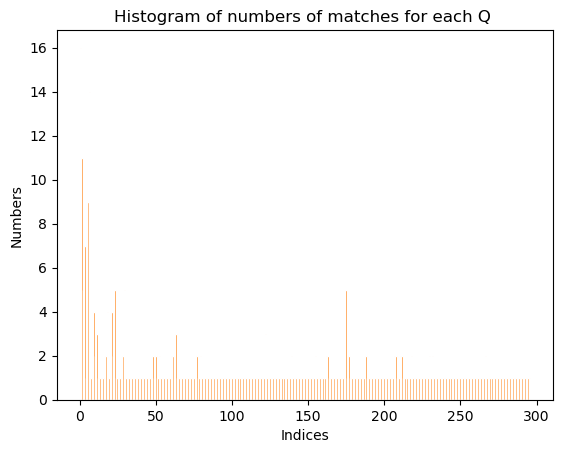

Highest 10:

Index: 0, Matches: 16, Percentage: 3.99%
Index: 6, Matches: 14, Percentage: 3.49%
Index: 1, Matches: 11, Percentage: 2.74%
Index: 5, Matches: 9, Percentage: 2.24%
Index: 3, Matches: 7, Percentage: 1.75%
Index: 175, Matches: 5, Percentage: 1.25%
Index: 29, Matches: 5, Percentage: 1.25%
Index: 23, Matches: 5, Percentage: 1.25%
Index: 2, Matches: 5, Percentage: 1.25%
Index: 21, Matches: 4, Percentage: 1.00%


Lowest 10:

Index: 4, Matches: 1, Percentage: 0.25%
Index: 7, Matches: 1, Percentage: 0.25%
Index: 8, Matches: 1, Percentage: 0.25%
Index: 12, Matches: 1, Percentage: 0.25%
Index: 13, Matches: 1, Percentage: 0.25%
Index: 14, Matches: 1, Percentage: 0.25%
Index: 15, Matches: 1, Percentage: 0.25%
Index: 16, Matches: 1, Percentage: 0.25%
Index: 19, Matches: 1, Percentage: 0.25%
Index: 20, Matches: 1, Percentage: 0.25%
Index: 24, Matches: 1, Percentage: 0.25%
Index: 25, Matches: 1, Percentage: 0.25%
Index: 26, Matches: 1, Percentage: 0.25%
Index: 27, Matches: 1, Percentage: 

In [35]:
indexes = range(len(sum_i_columns))

# Plotting the histogram
plt.hist(indexes, bins=len(sum_i_columns), weights=sum_i_columns, color='C1', edgecolor='white')

# Adding labels and title
plt.xlabel('Indices')
plt.ylabel('Numbers')
plt.title('Histogram of numbers of matches for each Q ')

# Display the histogram
plt.show()


# Compute the highest and lowest 10 values and their indexes
sorted_indices = sorted(range(len(sum_i_columns)), key=lambda i: sum_i_columns[i])
lowest_10_indices = sorted_indices[:20]
highest_10_indices = sorted_indices[-10:][::-1]  # Reverse to get in descending order

total_windows = len(Matrix_Matches)

# Print the highest and lowest 10 values and their indexes with percentages
print("Highest 10:\n")
for i in highest_10_indices:
    percentage = (sum_i_columns[i] / total_windows) * 100
    print(f"Index: {i}, Matches: {sum_i_columns[i]}, Percentage: {percentage:.2f}%")

print("\n\nLowest 10:\n")
for i in lowest_10_indices:
    percentage = (sum_i_columns[i] / total_windows) * 100
    print(f"Index: {i}, Matches: {sum_i_columns[i]}, Percentage: {percentage:.2f}%")

    
    


# 

# 

# 

# 


# sort the queries(with one match) by the max nearst distance of each one 


In [36]:
import numpy as np

# Convert sorted_indices and sum_i_columns to numpy arrays if they aren't already
sorted_indices = np.array(sorted_indices)
sum_i_columns = np.array(sum_i_columns)

# Use a boolean mask to find indices where sum_i_columns is less than or equal to 1
mask = sum_i_columns[sorted_indices] <= 1

# Get the corresponding indices
indices_1_match = sorted_indices[mask]

# Assuming dis is already a numpy array or convert it if necessary
dis = np.array(dis)

# Use indices_1_match to index dis
dis_1_match = dis[indices_1_match]

# Sort dis_1_match and get the sorted indices
sorted_dis_1_match_indices = np.argsort(dis_1_match)

# Sort indices_1_match based on sorted_dis_1_match_indices
sorted_indices_1_match = indices_1_match[sorted_dis_1_match_indices]

# Result: sorted indices of sum_i_columns based on sorted dis_1_match values
sorted_indices_1_match


array([ 13,  19, 270,  38, 209, 274,  12, 101, 159,  14,  15, 236, 254,
       231,  24,  91,  85,  71, 283,  51,  32,  25, 126, 158, 161, 160,
        26, 226,  54, 215, 233,  20, 121,   8, 272,   7, 258, 217, 229,
       116,  44, 110,  97, 146,  27, 219, 202, 265, 253, 251, 206, 147,
       118,  37,  68, 268, 259, 260,  39,  45,  47, 216, 249, 137, 220,
       214, 228, 257, 165, 127, 167,  78,  59, 252, 243,  75,  99, 176,
       164,  42, 136, 262, 204, 130,   4, 255, 125, 242,  56, 174,  34,
       102, 142,  57, 227,  65,  95, 234, 248, 141,  30,  93, 106, 288,
        35,  31,  81,  46, 108, 222, 129, 123,  64, 198, 256, 134, 100,
        89,  33,  76, 113, 235,  90, 246,  72, 145, 104, 105, 114,  43,
       143, 151,  96, 150,  66,  58, 111,  74, 278, 205,  41, 276, 166,
       119, 156, 245, 135,  69,  36, 157, 244, 261, 213,  73, 115, 103,
        67, 250,  88,  87, 112, 120, 286, 149, 131, 241, 271,  40, 132,
       140, 279, 239, 133, 154, 237, 223, 285,  98,  70, 144,  8

# 

# 

In [37]:
import ipywidgets as widgets

def on_button_clicked(k,l):
    print("Button clicked:")
    plot_distance_flux(k,l)

# Create the button widget


In [38]:
indexes_5 = [1850,1971,2289,2290,2535,2536,2583,2932,2933,3240,]

###################  m =  7 ######################
----------------------------------------------------------------------------------------------------------- 7 

----------------------------------------NEW OBJECT --------------------------------------------------------

-----------------------------------------------------------------------------------------------------------

Q[7] , Matches on this Query: 1
Nb_valid 15
Ratio : 1.4042877406209087
Object of this Q : ZTF18abjrjzx : https://fink-portal.org/ZTF18abjrjzx

Number of objects that have matches on this Q : 1
Objects that have matches on this Q :  [436] 

https://fink-portal.org/ZTF18abjrjzx  : Nb of mathces :  1


Button(description='plot ZTF18abjrjzx', style=ButtonStyle())



______________________________________________________________________________________________
ZTF18abjrjzx
                        BlueSG* : 98.2% 
                        Unknown : 1.6% 
                        EmObj : 0.2% 


Button(description='open in FINK', style=ButtonStyle())

This window is used as the 7th query! 


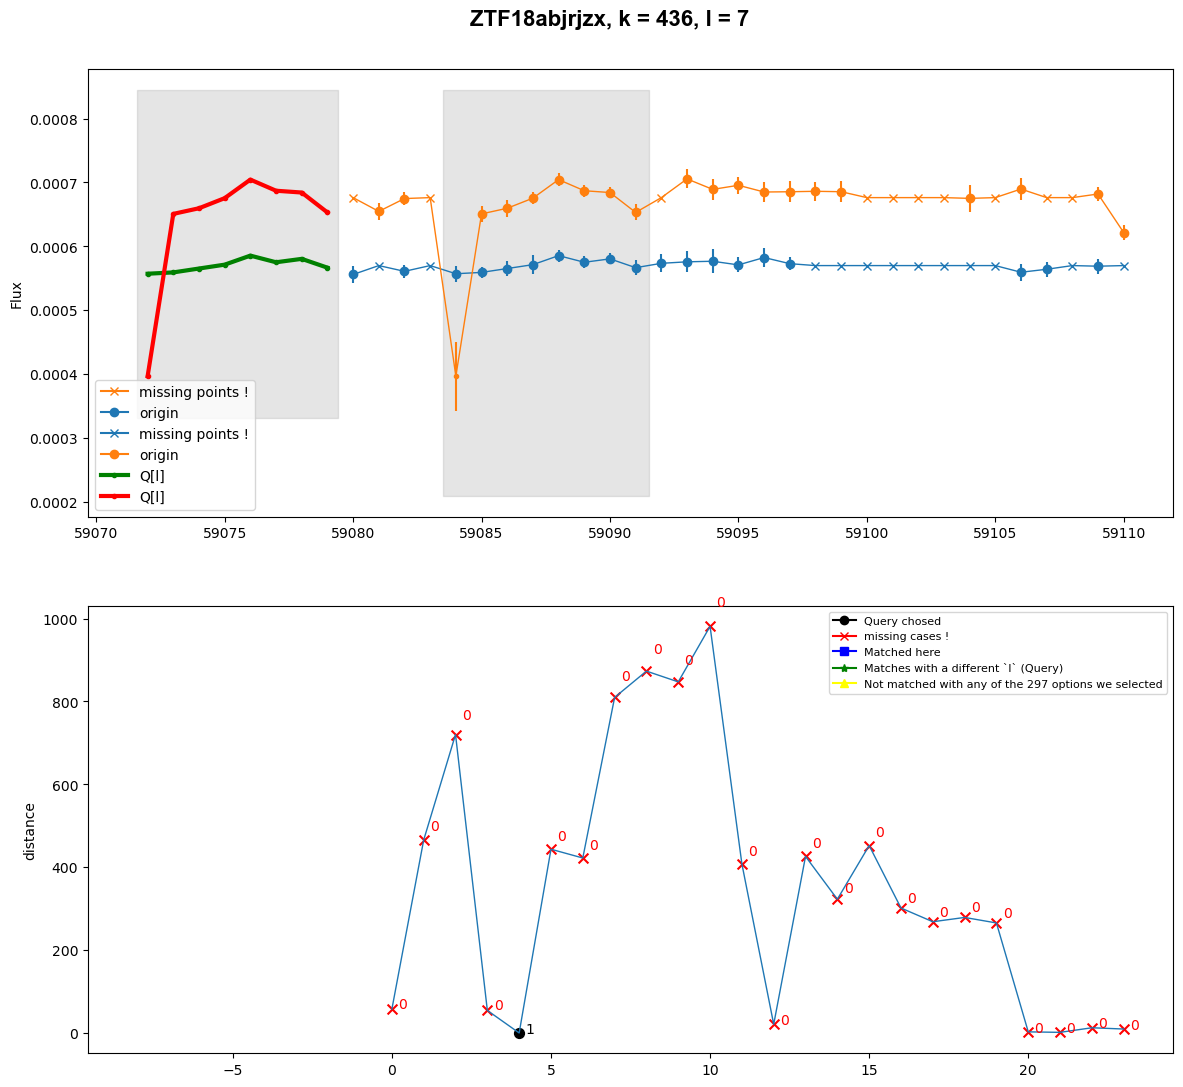

----------------------------------------------------------------------------------------------------------- 121 

----------------------------------------NEW OBJECT --------------------------------------------------------

-----------------------------------------------------------------------------------------------------------

Q[121] , Matches on this Query: 1
Nb_valid 15
Ratio : 0.44889241490897036
Object of this Q : ZTF17aabregl : https://fink-portal.org/ZTF17aabregl

Number of objects that have matches on this Q : 1
Objects that have matches on this Q :  [8165] 

https://fink-portal.org/ZTF17aabregl  : Nb of mathces :  1


Button(description='plot ZTF17aabregl', style=ButtonStyle())



______________________________________________________________________________________________
ZTF17aabregl
                        EB* : 95.2% 
                        QSO : 2.5% 
                        Unknown : 2.3% 


Button(description='open in FINK', style=ButtonStyle())

This window is used as the 121th query! 


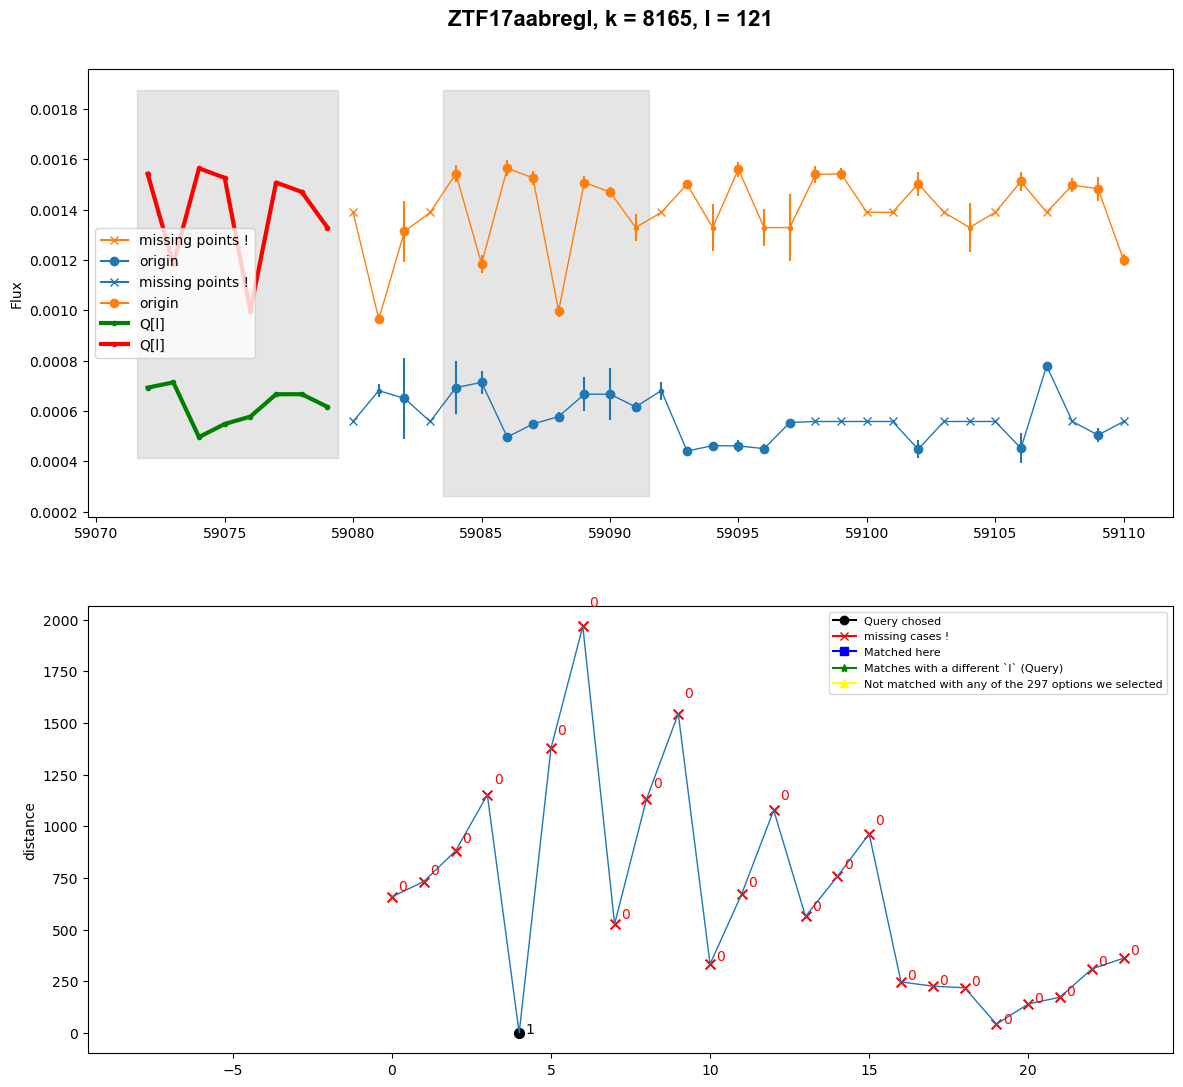

----------------------------------------------------------------------------------------------------------- 126 

----------------------------------------NEW OBJECT --------------------------------------------------------

-----------------------------------------------------------------------------------------------------------

Q[126] , Matches on this Query: 1
Nb_valid 15
Ratio : 0.23017741471941214
Object of this Q : ZTF18abgjfze : https://fink-portal.org/ZTF18abgjfze

Number of objects that have matches on this Q : 1
Objects that have matches on this Q :  [8294] 

https://fink-portal.org/ZTF18abgjfze  : Nb of mathces :  1


Button(description='plot ZTF18abgjfze', style=ButtonStyle())



______________________________________________________________________________________________
ZTF18abgjfze
                        EB* : 97.3% 
                        Unknown : 2.7% 


Button(description='open in FINK', style=ButtonStyle())

This window is used as the 126th query! 


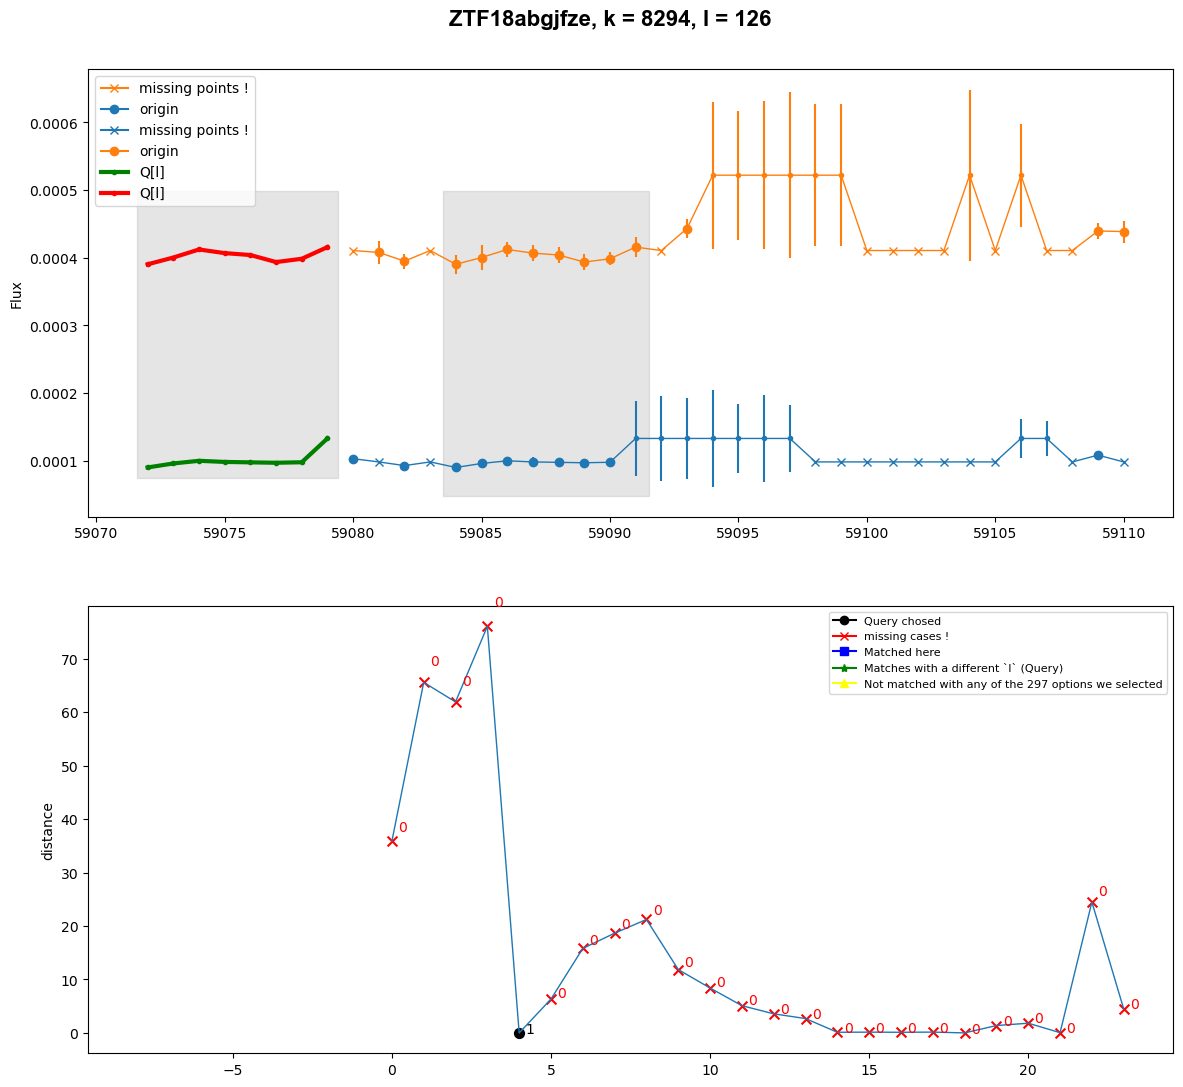

----------------------------------------------------------------------------------------------------------- 144 

----------------------------------------NEW OBJECT --------------------------------------------------------

-----------------------------------------------------------------------------------------------------------

Q[144] , Matches on this Query: 1
Nb_valid 15
Ratio : 0.708299456814228
Object of this Q : ZTF17aaaevux : https://fink-portal.org/ZTF17aaaevux

Number of objects that have matches on this Q : 1
Objects that have matches on this Q :  [8689] 

https://fink-portal.org/ZTF17aaaevux  : Nb of mathces :  1


Button(description='plot ZTF17aaaevux', style=ButtonStyle())



______________________________________________________________________________________________
ZTF17aaaevux
                        EB* : 97.9% 
                        Unknown : 1.5% 
                        PM* : 0.6% 


Button(description='open in FINK', style=ButtonStyle())

This window is used as the 144th query! 


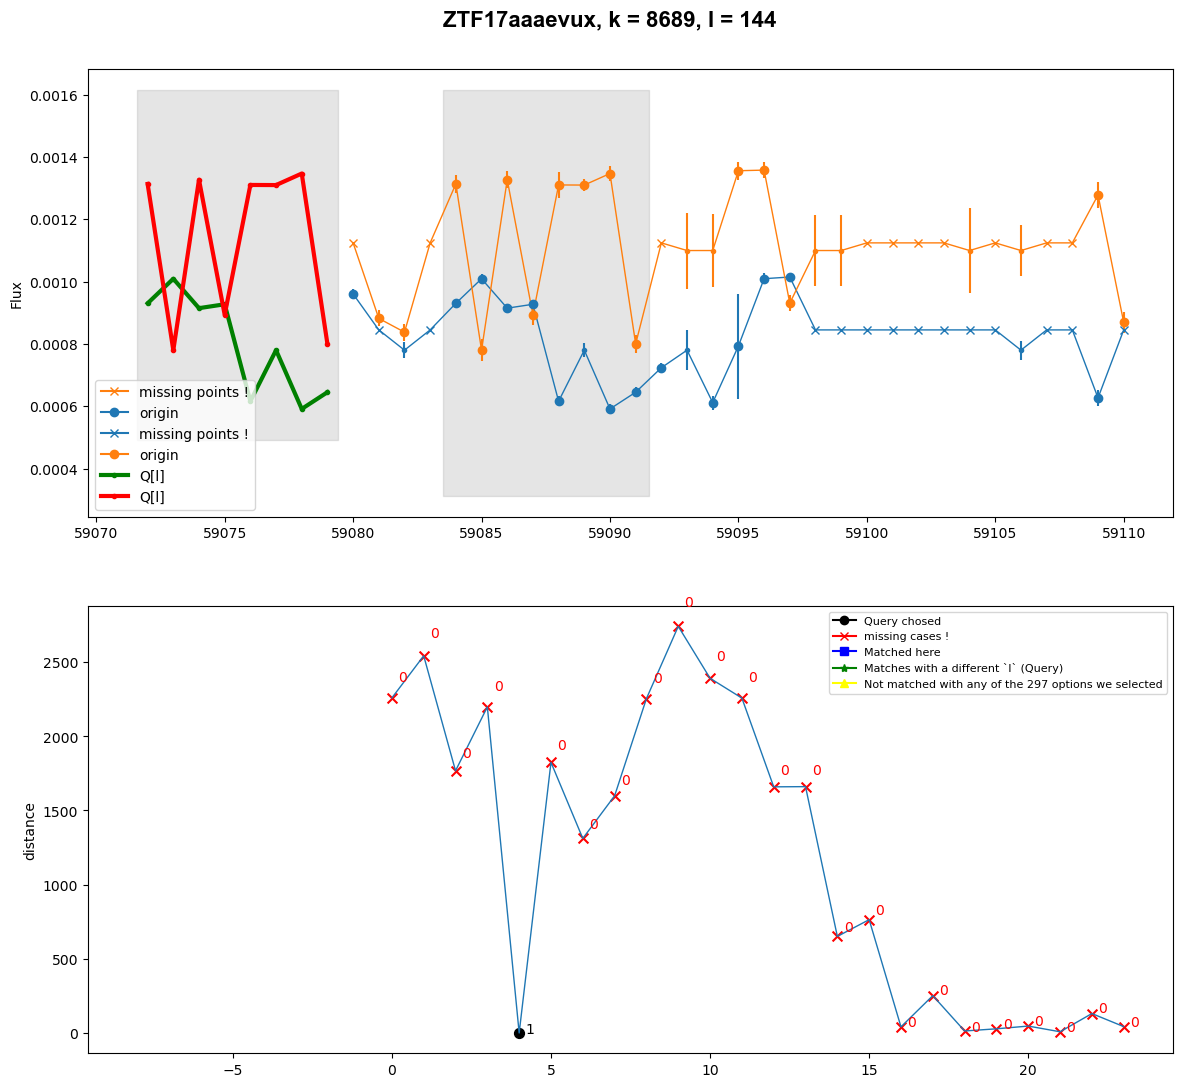

----------------------------------------------------------------------------------------------------------- 179 

----------------------------------------NEW OBJECT --------------------------------------------------------

-----------------------------------------------------------------------------------------------------------

Q[179] , Matches on this Query: 1
Nb_valid 15
Ratio : 0.7881063948844035
Object of this Q : ZTF18abosyao : https://fink-portal.org/ZTF18abosyao

Number of objects that have matches on this Q : 1
Objects that have matches on this Q :  [13303] 

https://fink-portal.org/ZTF18abosyao  : Nb of mathces :  1


Button(description='plot ZTF18abosyao', style=ButtonStyle())



______________________________________________________________________________________________
ZTF18abosyao
                        RRLyr : 98.6% 
                        Unknown : 1.4% 


Button(description='open in FINK', style=ButtonStyle())

This window is used as the 179th query! 


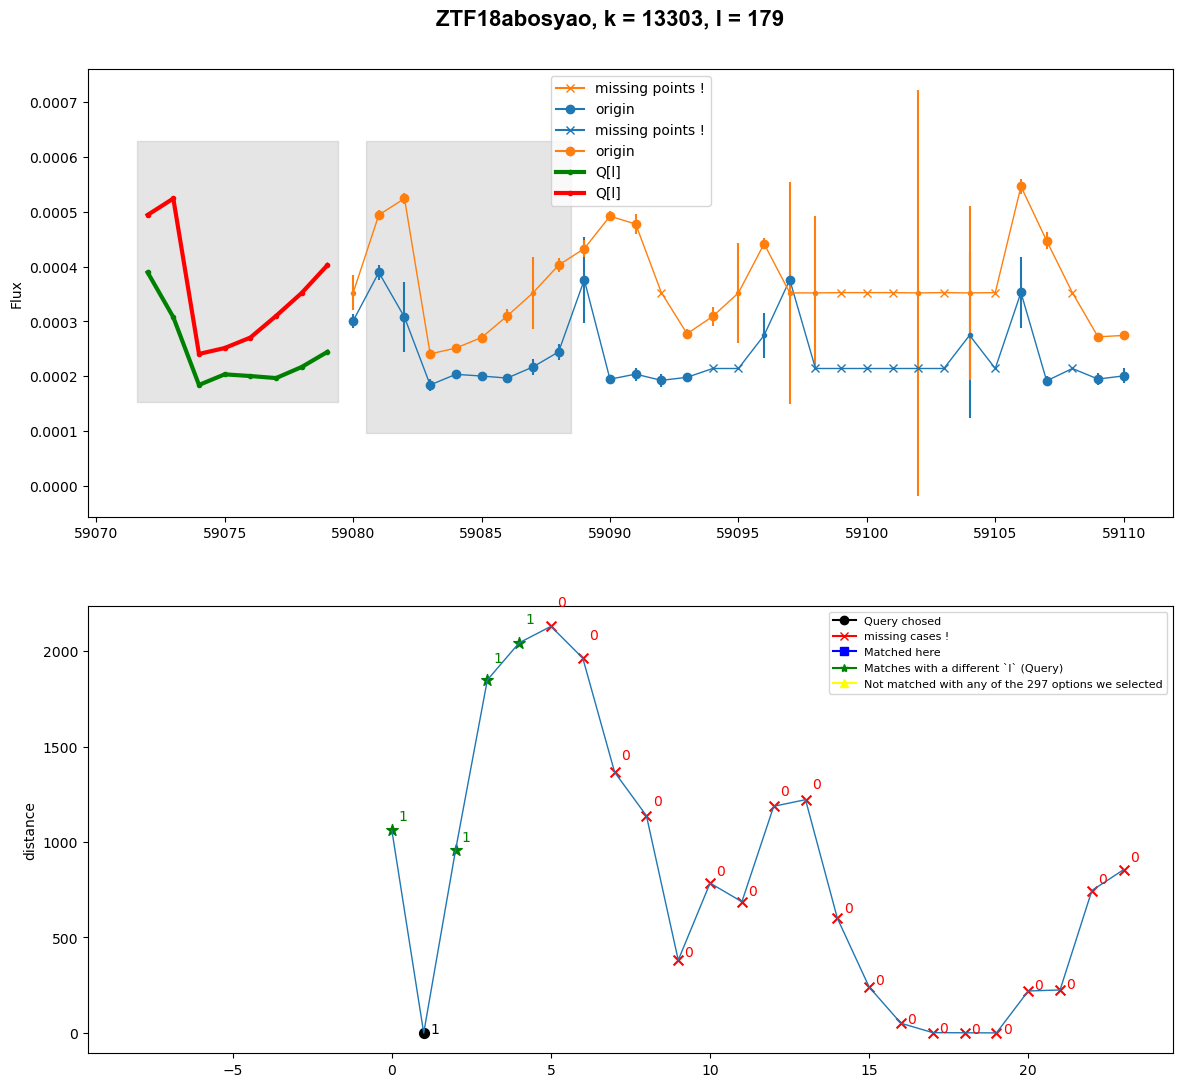

----------------------------------------------------------------------------------------------------------- 180 

----------------------------------------NEW OBJECT --------------------------------------------------------

-----------------------------------------------------------------------------------------------------------

Q[180] , Matches on this Query: 1
Nb_valid 15
Ratio : 0.5871659963223647
Object of this Q : ZTF18abosyao : https://fink-portal.org/ZTF18abosyao

Number of objects that have matches on this Q : 1
Objects that have matches on this Q :  [13303] 

https://fink-portal.org/ZTF18abosyao  : Nb of mathces :  1


Button(description='plot ZTF18abosyao', style=ButtonStyle())



______________________________________________________________________________________________
ZTF18abosyao
                        RRLyr : 98.6% 
                        Unknown : 1.4% 


Button(description='open in FINK', style=ButtonStyle())

This window is used as the 180th query! 


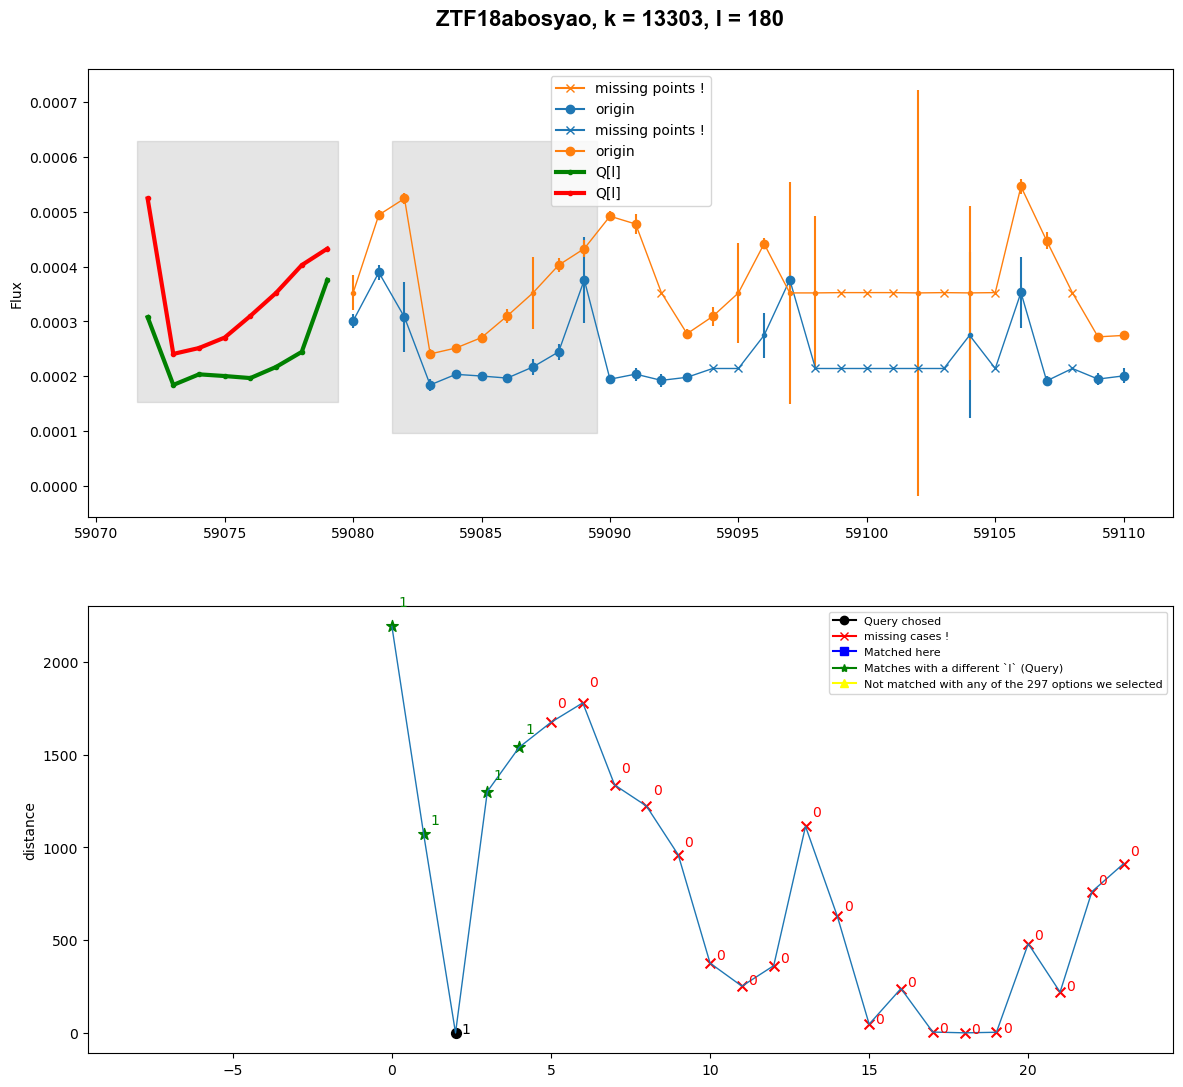

----------------------------------------------------------------------------------------------------------- 181 

----------------------------------------NEW OBJECT --------------------------------------------------------

-----------------------------------------------------------------------------------------------------------

Q[181] , Matches on this Query: 1
Nb_valid 15
Ratio : 0.7651555447556287
Object of this Q : ZTF18abosyao : https://fink-portal.org/ZTF18abosyao

Number of objects that have matches on this Q : 1
Objects that have matches on this Q :  [13303] 

https://fink-portal.org/ZTF18abosyao  : Nb of mathces :  1


Button(description='plot ZTF18abosyao', style=ButtonStyle())



______________________________________________________________________________________________
ZTF18abosyao
                        RRLyr : 98.6% 
                        Unknown : 1.4% 


Button(description='open in FINK', style=ButtonStyle())

This window is used as the 181th query! 


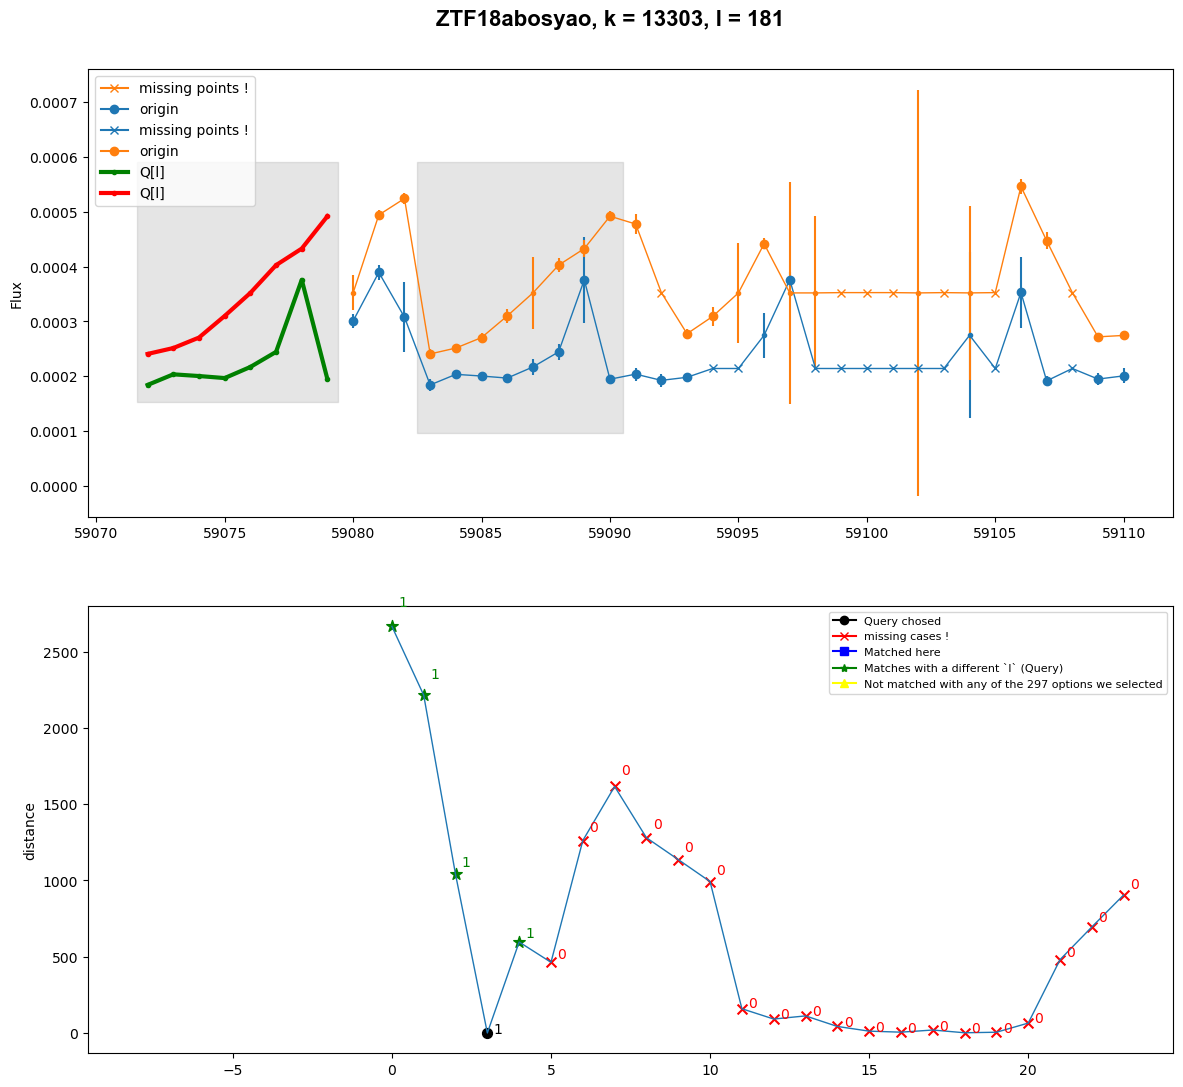

----------------------------------------------------------------------------------------------------------- 182 

----------------------------------------NEW OBJECT --------------------------------------------------------

-----------------------------------------------------------------------------------------------------------

Q[182] , Matches on this Query: 1
Nb_valid 15
Ratio : 0.8093823835277815
Object of this Q : ZTF18abosyao : https://fink-portal.org/ZTF18abosyao

Number of objects that have matches on this Q : 1
Objects that have matches on this Q :  [13303] 

https://fink-portal.org/ZTF18abosyao  : Nb of mathces :  1


Button(description='plot ZTF18abosyao', style=ButtonStyle())



______________________________________________________________________________________________
ZTF18abosyao
                        RRLyr : 98.6% 
                        Unknown : 1.4% 


Button(description='open in FINK', style=ButtonStyle())

This window is used as the 182th query! 


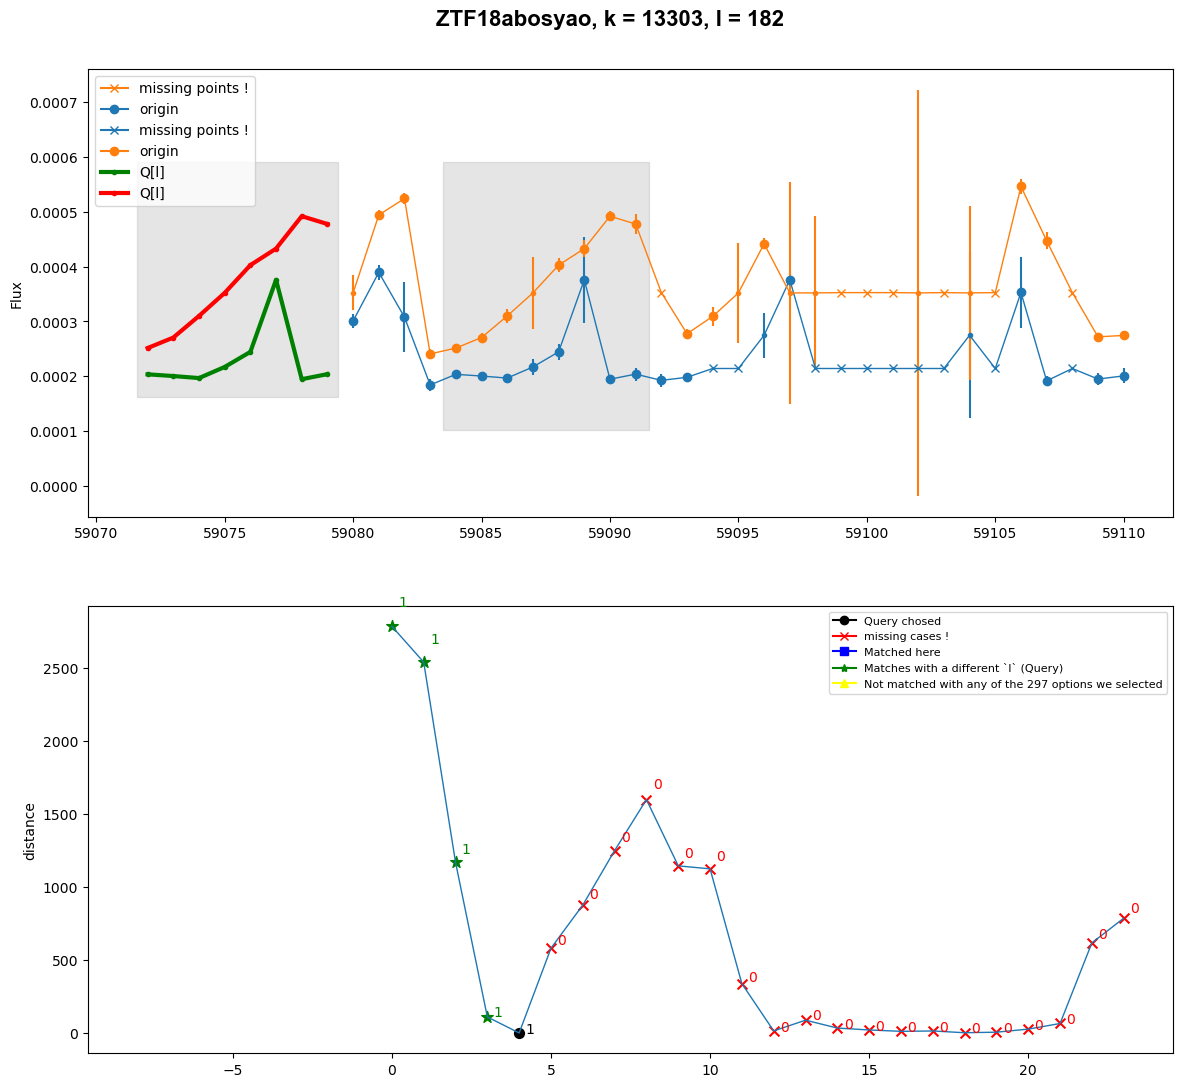

----------------------------------------------------------------------------------------------------------- 187 

----------------------------------------NEW OBJECT --------------------------------------------------------

-----------------------------------------------------------------------------------------------------------

Q[187] , Matches on this Query: 1
Nb_valid 15
Ratio : 0.9937282138343098
Object of this Q : ZTF17aabvmxy : https://fink-portal.org/ZTF17aabvmxy

Number of objects that have matches on this Q : 1
Objects that have matches on this Q :  [13429] 

https://fink-portal.org/ZTF17aabvmxy  : Nb of mathces :  1


Button(description='plot ZTF17aabvmxy', style=ButtonStyle())



______________________________________________________________________________________________
ZTF17aabvmxy
                        RRLyr : 97.5% 
                        Unknown : 2.5% 


Button(description='open in FINK', style=ButtonStyle())

This window is used as the 187th query! 


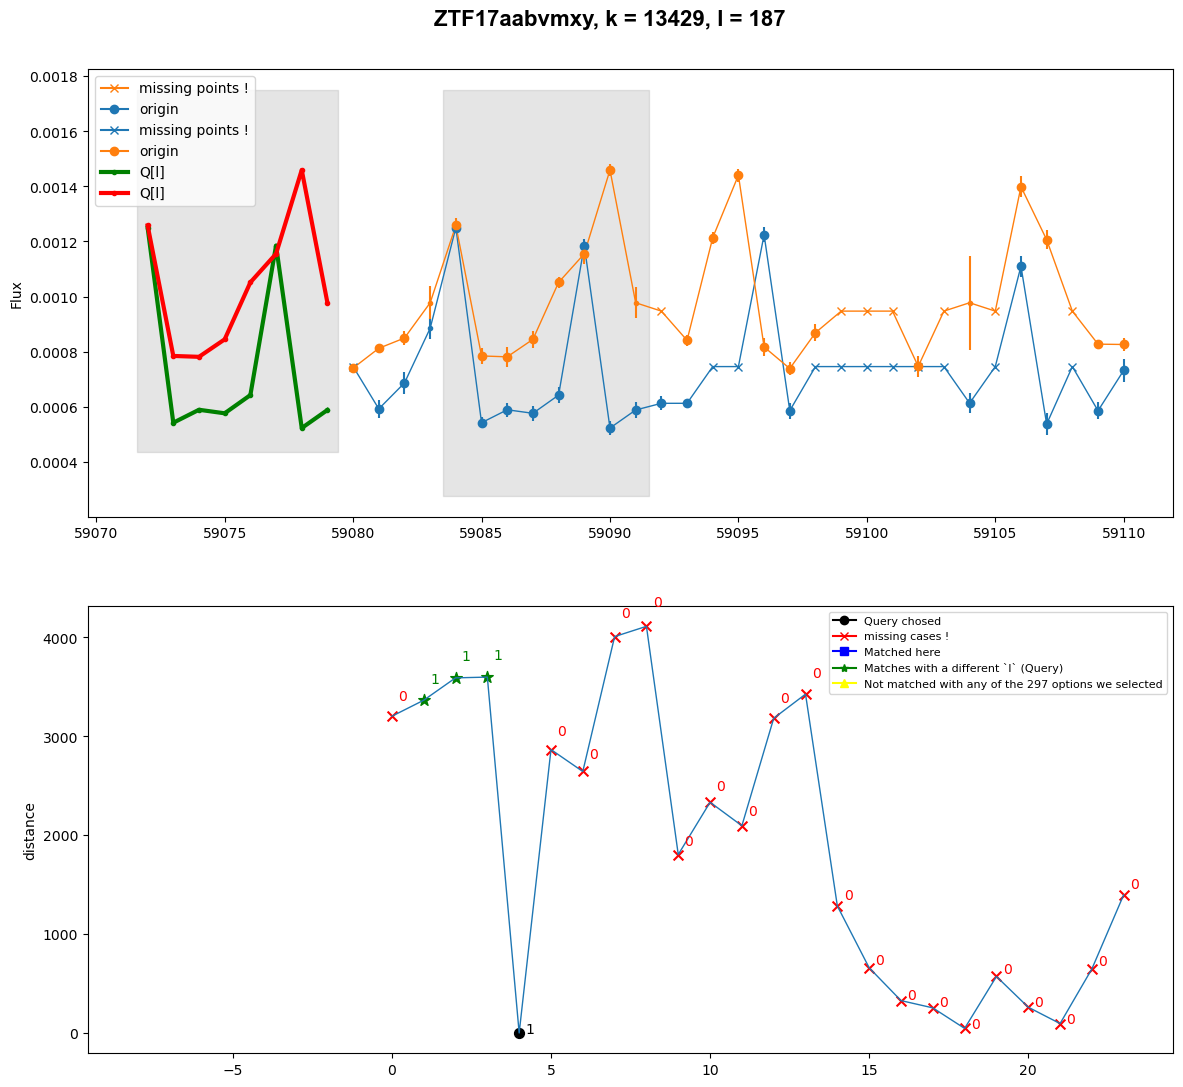

----------------------------------------------------------------------------------------------------------- 197 

----------------------------------------NEW OBJECT --------------------------------------------------------

-----------------------------------------------------------------------------------------------------------

Q[197] , Matches on this Query: 1
Nb_valid 15
Ratio : 1.654796110049003
Object of this Q : ZTF17aaadvep : https://fink-portal.org/ZTF17aaadvep

Number of objects that have matches on this Q : 1
Objects that have matches on this Q :  [14906] 

https://fink-portal.org/ZTF17aaadvep  : Nb of mathces :  1


Button(description='plot ZTF17aaadvep', style=ButtonStyle())



______________________________________________________________________________________________
ZTF17aaadvep
                        RRLyr : 98.8% 
                        Unknown : 0.9% 
                        WD*_Candidate : 0.3% 


Button(description='open in FINK', style=ButtonStyle())

This window is used as the 197th query! 


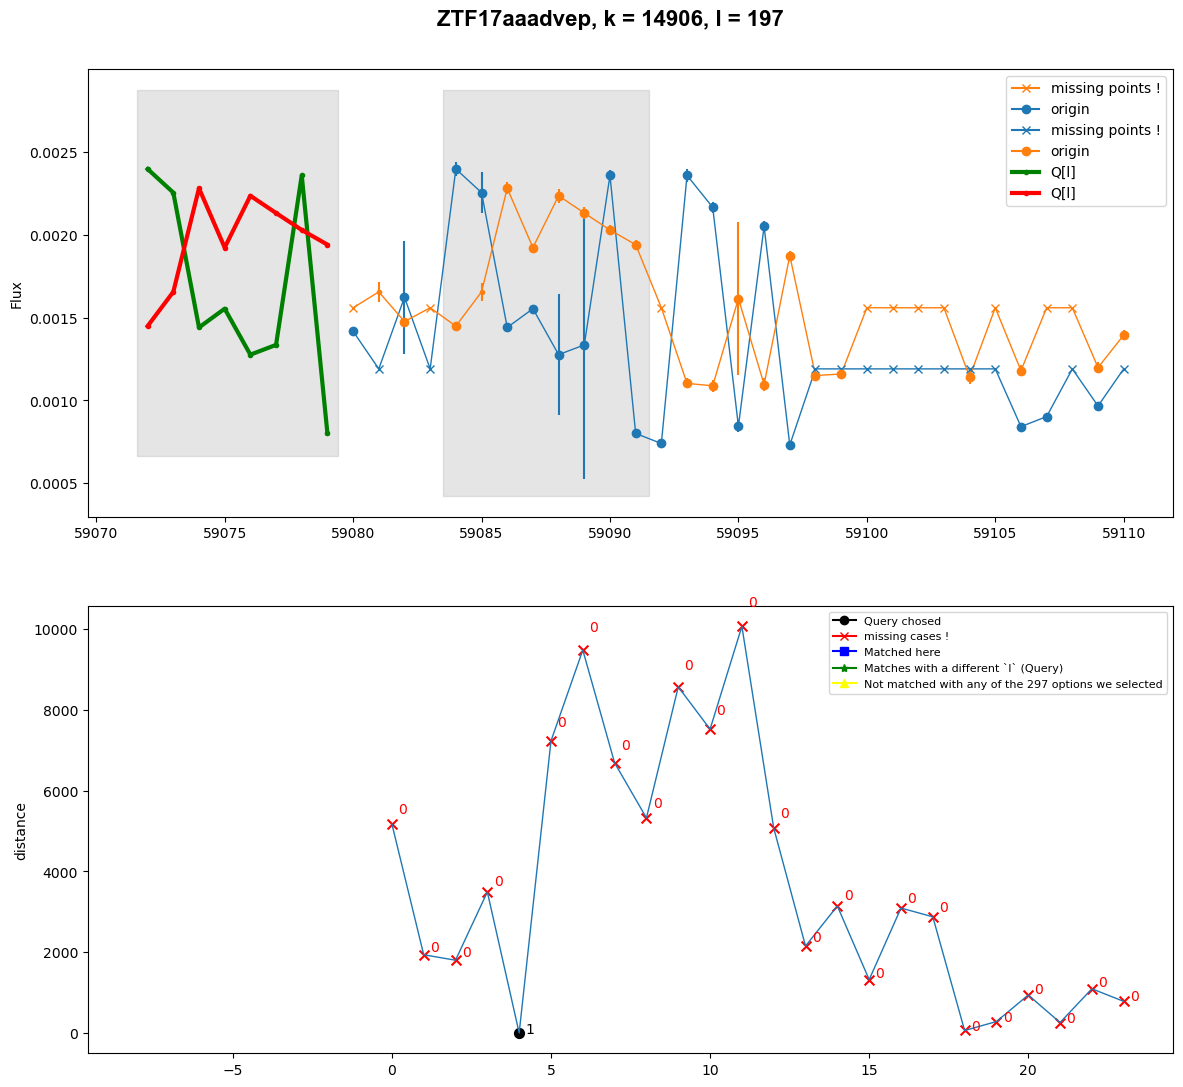

----------------------------------------------------------------------------------------------------------- 203 

----------------------------------------NEW OBJECT --------------------------------------------------------

-----------------------------------------------------------------------------------------------------------

Q[203] , Matches on this Query: 1
Nb_valid 15
Ratio : 0.6468058407796277
Object of this Q : ZTF19aaahttn : https://fink-portal.org/ZTF19aaahttn

Number of objects that have matches on this Q : 1
Objects that have matches on this Q :  [17435] 

https://fink-portal.org/ZTF19aaahttn  : Nb of mathces :  1


Button(description='plot ZTF19aaahttn', style=ButtonStyle())



______________________________________________________________________________________________
ZTF19aaahttn
                        Unknown : 99.5% 
                        Microlensing candidate : 0.5% 


Button(description='open in FINK', style=ButtonStyle())

This window is used as the 203th query! 


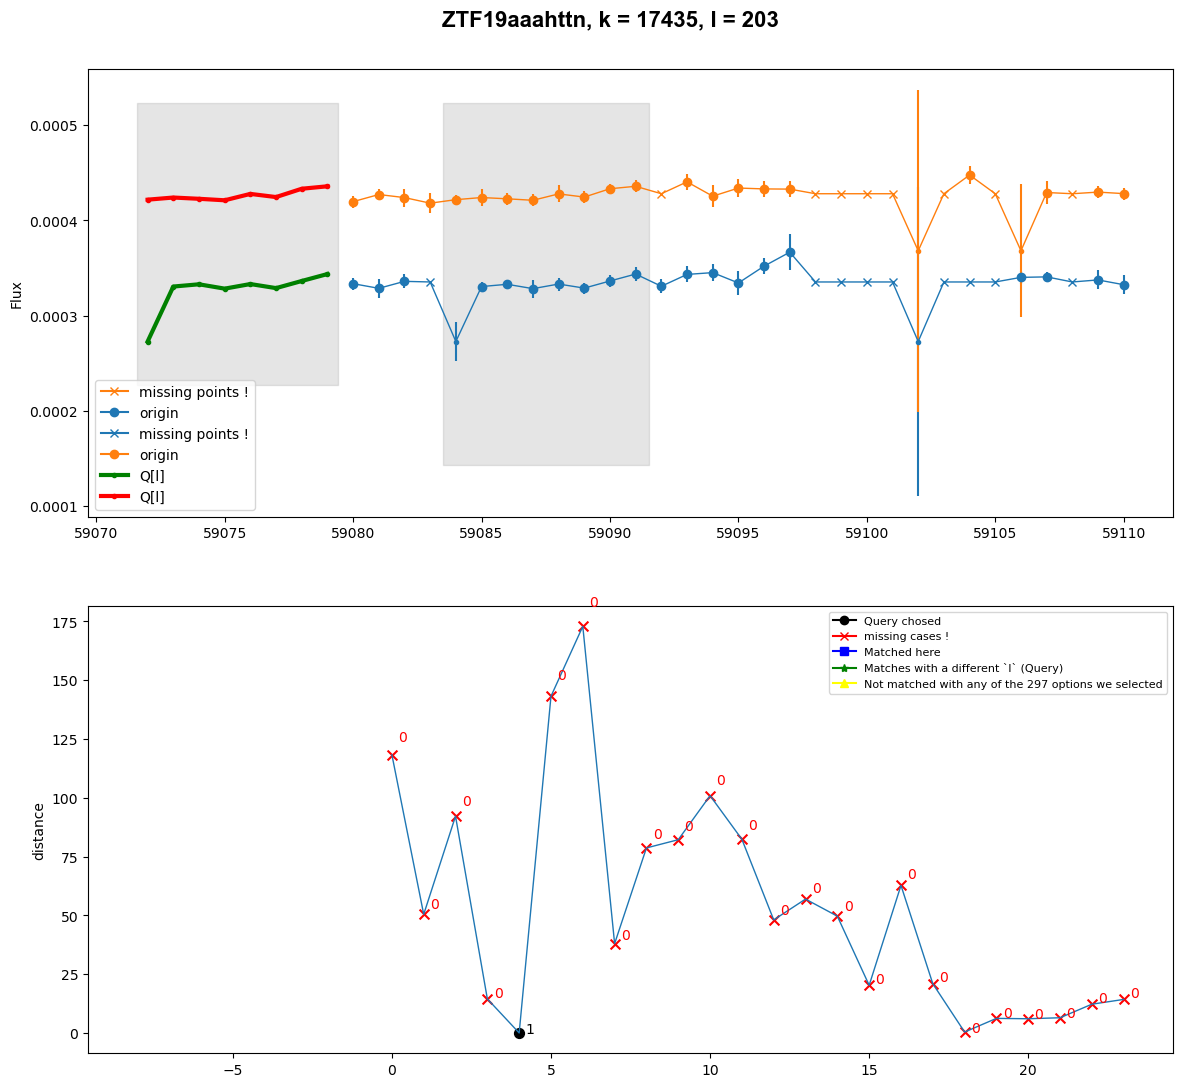

----------------------------------------------------------------------------------------------------------- 213 

----------------------------------------NEW OBJECT --------------------------------------------------------

-----------------------------------------------------------------------------------------------------------

Q[213] , Matches on this Query: 1
Nb_valid 16
Ratio : 1.1647882052851162
Object of this Q : ZTF18abgjgiq : https://fink-portal.org/ZTF18abgjgiq

Number of objects that have matches on this Q : 1
Objects that have matches on this Q :  [19522] 

https://fink-portal.org/ZTF18abgjgiq  : Nb of mathces :  1


Button(description='plot ZTF18abgjgiq', style=ButtonStyle())



______________________________________________________________________________________________
ZTF18abgjgiq
                        Unknown : 93.2% 
                        CataclyV* : 6.8% 


Button(description='open in FINK', style=ButtonStyle())

This window is used as the 213th query! 


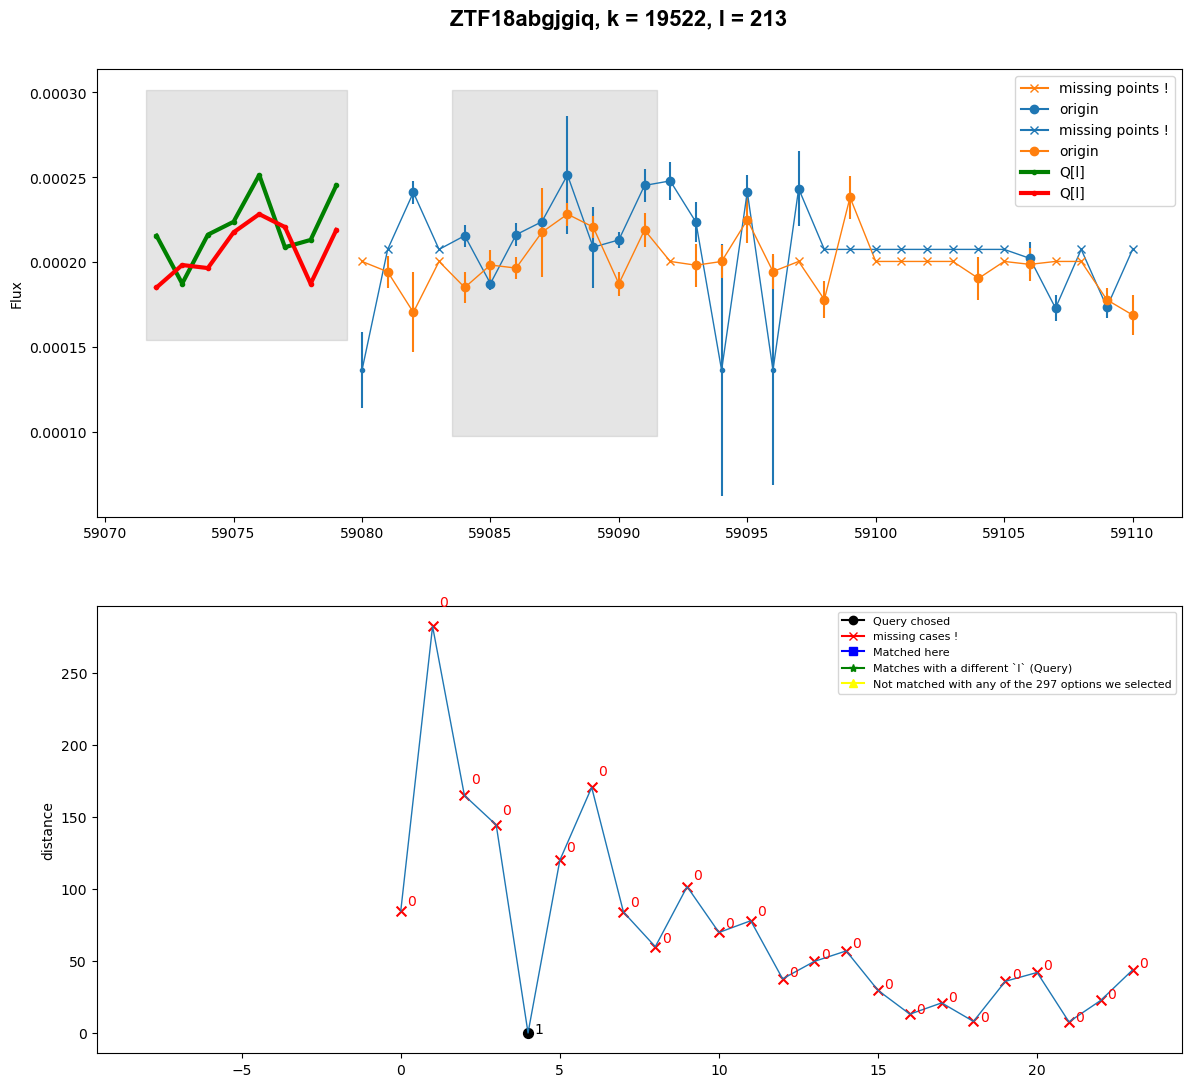

----------------------------------------------------------------------------------------------------------- 239 

----------------------------------------NEW OBJECT --------------------------------------------------------

-----------------------------------------------------------------------------------------------------------

Q[239] , Matches on this Query: 1
Nb_valid 15
Ratio : 1.0624405107357593
Object of this Q : ZTF18acdyfff : https://fink-portal.org/ZTF18acdyfff

Number of objects that have matches on this Q : 1
Objects that have matches on this Q :  [22049] 

https://fink-portal.org/ZTF18acdyfff  : Nb of mathces :  1


Button(description='plot ZTF18acdyfff', style=ButtonStyle())



______________________________________________________________________________________________
ZTF18acdyfff
                        Unknown : 100.0% 


Button(description='open in FINK', style=ButtonStyle())

This window is used as the 239th query! 


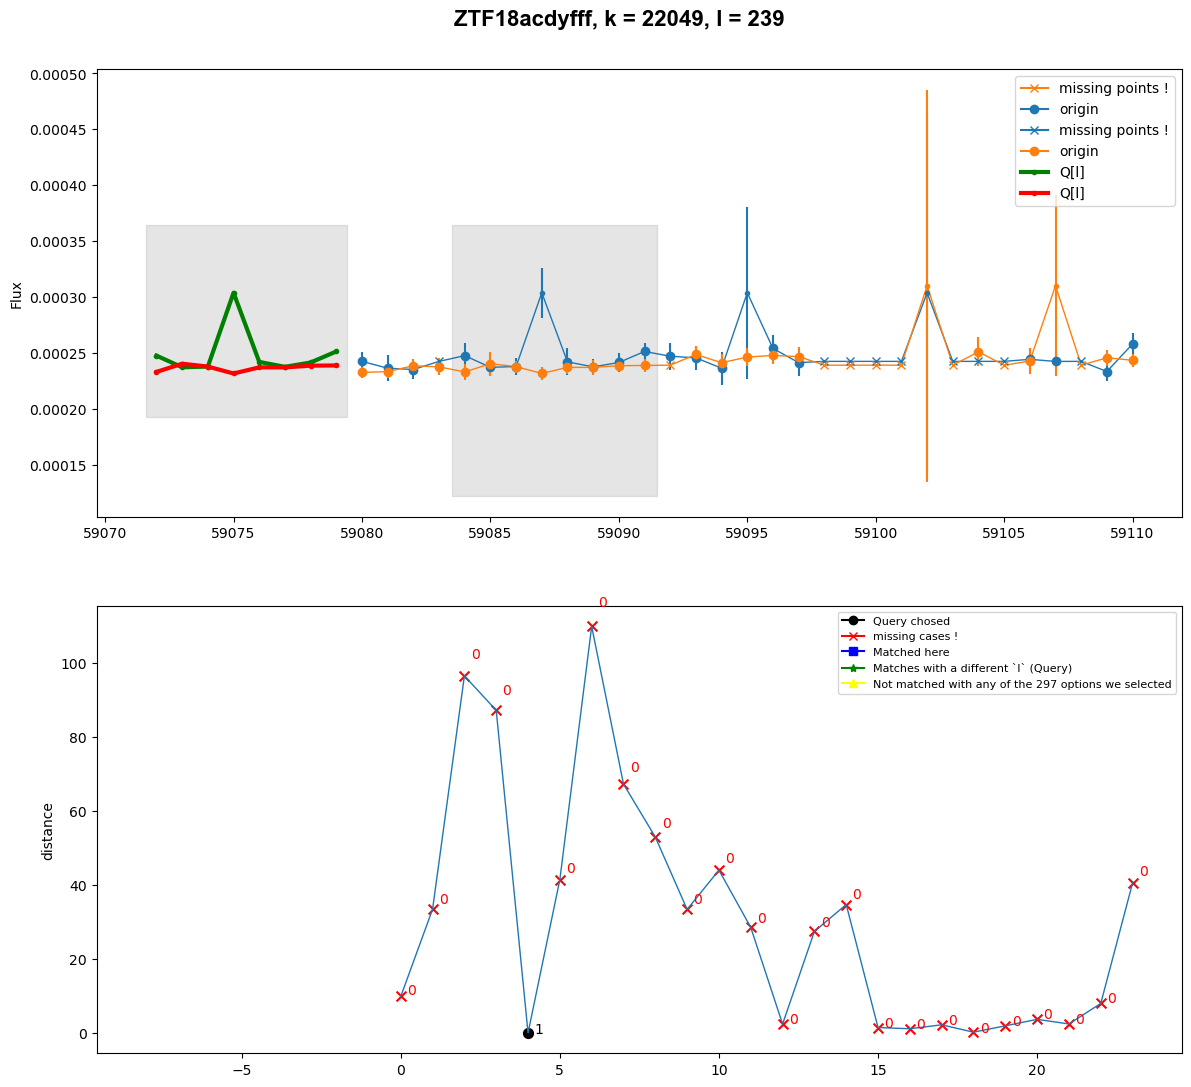

----------------------------------------------------------------------------------------------------------- 283 

----------------------------------------NEW OBJECT --------------------------------------------------------

-----------------------------------------------------------------------------------------------------------

Q[283] , Matches on this Query: 1
Nb_valid 16
Ratio : 0.40417112091518087
Object of this Q : ZTF18abhqcyx : https://fink-portal.org/ZTF18abhqcyx

Number of objects that have matches on this Q : 1
Objects that have matches on this Q :  [30574] 

https://fink-portal.org/ZTF18abhqcyx  : Nb of mathces :  1


Button(description='plot ZTF18abhqcyx', style=ButtonStyle())



______________________________________________________________________________________________
ZTF18abhqcyx
                        V* : 98.3% 
                        Unknown : 1.7% 


Button(description='open in FINK', style=ButtonStyle())

This window is used as the 283th query! 


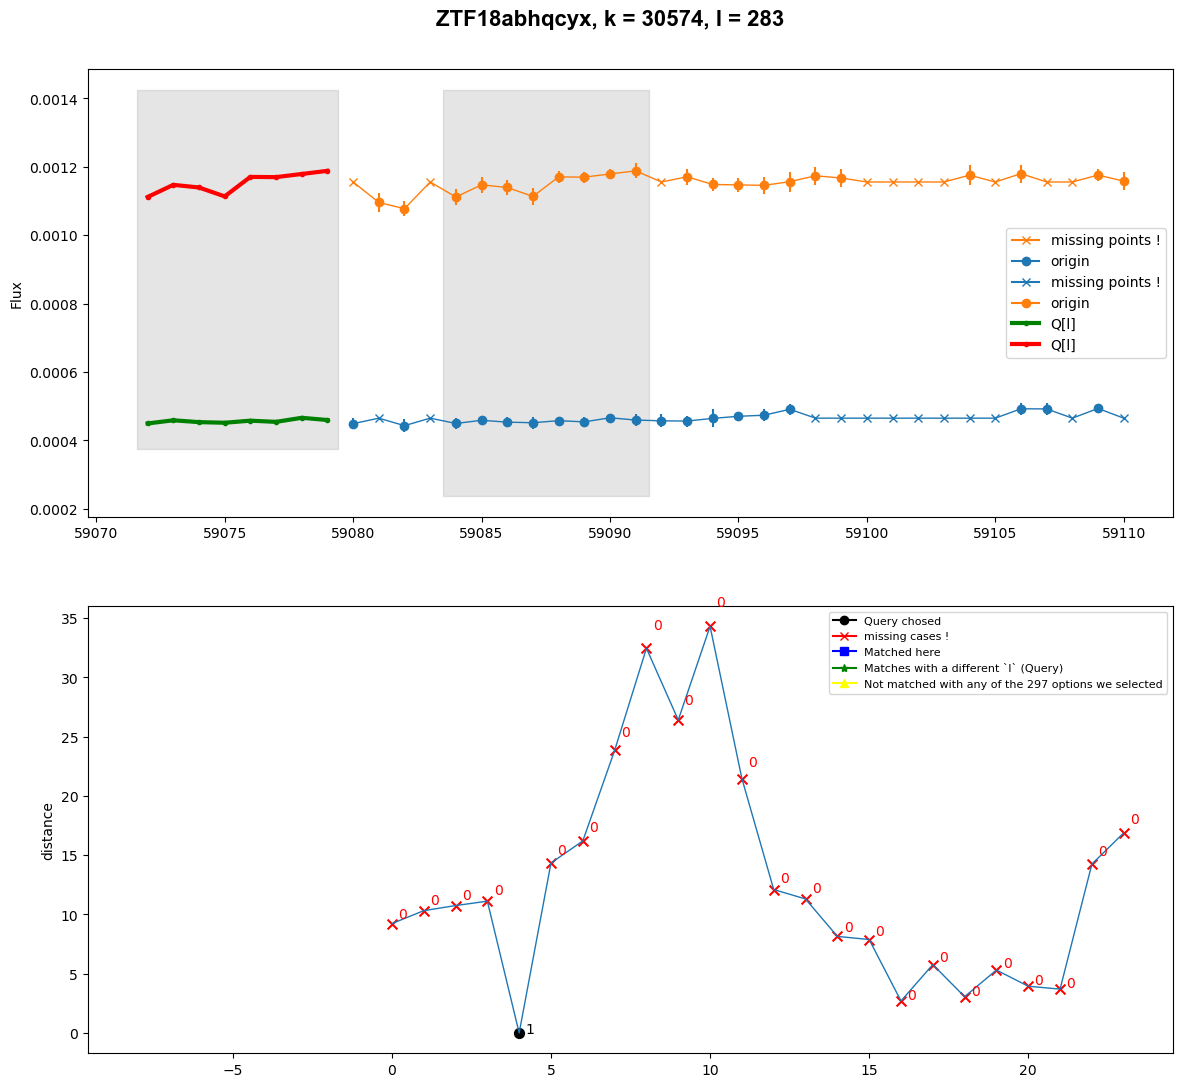

In [42]:
print("###################  m = ", m ,"######################")
c= 0 
for l in sorted_indices:#sorted_indices_1_match[::-1]:#sorted_indices:#[0:1549]:
#for l in indexes_5:
    #l = sorted_indices[r]
    k , i = selected_Q_K_i[l]
    Nb_valid = np.sum(is_valid[objects[k]][i*2:i*2+chunk_size])

    if Nb_valid < chunk_size -1:
        continue
    if sum_i_columns[l] >1 :
            break 
    c+=1
    
    print("-----------------------------------------------------------------------------------------------------------",l,"\n")
    print("----------------------------------------NEW OBJECT --------------------------------------------------------\n")
    print("-----------------------------------------------------------------------------------------------------------\n")
    print(f"Q[{l}] , Matches on this Query: {sum_i_columns[l]}")
    
    print('Nb_valid', Nb_valid)

    

    
    print("Ratio :",Q[l][0]/Q[l][1])
    
    print(f"Object of this Q : {objects[k]} : https://fink-portal.org/{objects[k]}")

    
    non_zero_indexes = np.nonzero(num_by_obj[l])[0]
    non_zero_indexes, len(non_zero_indexes)
    print("\nNumber of objects that have matches on this Q :", len(non_zero_indexes))
    print("Objects that have matches on this Q : ", non_zero_indexes,"\n")
    
    for kk in non_zero_indexes:
        print(f"https://fink-portal.org/{objects[kk]}" , " : Nb of mathces : ",num_by_obj[l][kk])
        button = widgets.Button(description=f"plot {objects[kk]}")
        # Capture current values of kk and l in lambda's default arguments
        button.on_click(lambda _, kk=kk, l=l: on_button_clicked(kk, l))
        display(button)
        
    print()
    
    plot_distance_flux(k,l)

    """print("------------------------------- nearst query --------------------------------------------")

    l_nearst, d_nearst = nearst_query[l]
    k_nearst , i_nearst = selected_Q_K_i[l_nearst]
    
    if l_nearst < l:
        plot_distance_flux_min(k_nearst,l_nearst,i_nearst)
    else:
        plot_distance_flux_min(k_nearst,l,i_nearst)"""

    
    """print("------------------------------- nearst window with one match --------------------------------------------")

    k_nearst , i_nearst, d_nearst = nearst_window_1[l][0]
    # k_nearst , i_nearst = selected_Q_K_i[l_nearst]
    print(i_nearst)
    print("Distance = ",d_nearst)
    
    # plot_distance_flux(k_nearst,l)
    plot_distance_flux_min(k_nearst,l,i_nearst)
    

    print("------------------------------- nearst window --------------------------------------------")

    min_d_d  = min_d[3*l]
    min_d_k = min_d[3*l+1]
    min_d_i = min_d[3*l+2]
    
    if min_d_d != float('inf') : 
        # print(min_d_d, min_d_k,min_d_i)
        print("distance :",min_d_d)
        print("K :", min_d_k)
        print("mjd :", mjd[objects[k]][min_d_i*2])
        # plot_distance_flux(min_d_k,l)
        plot_distance_flux_min(min_d_k,l,min_d_i)
    else : 
        print("no min found")
        print("---------------------------------------------------------------------------")"""

    

In [ ]:
c,m

#

In [ ]:
import pandas as pd

# Assuming you have already imported numpy as np

# Create a list to store dictionaries with the information
data = []

for l in sorted_indices:#[0:10]:
    Q_ratio = (Q[l][::2]).sum()/(Q[l][1::2]).sum() / (m + 1)#Q[l][0] / Q[l][1]
    k, i = selected_Q_K_i[l]
    non_zero_indexes = np.nonzero(num_by_obj[l])[0]
    Nb_valid = np.sum(is_valid[objects[k]][i*2:i*2+chunk_size])
    url_and_matches = []
    for kk in non_zero_indexes:
        url_and_matches.append(f"https://fink-portal.org/{objects[kk]} : Nb of matches : {num_by_obj[l][kk]}")
    
    str = "" 
    for index, row in dataframes[objects[k]].iterrows():
        classification = row['classification']
        percentage = row['percentage']
        error_bar = row['error_bar']
        str += f"  {classification} : {percentage:.1f}% \n"
        
    # Create a dictionary for each iteration
    row = {
        'Query': l,
        'Matches on this Query': sum_i_columns[l],
        'Ratio': Q_ratio,
        'Object of this Q': objects[k],
        'Link': f"https://fink-portal.org/{objects[k]}",
        'class': str,
        'Nb_valid' : Nb_valid,
        'mjd ': mjd.loc[objects[k]][2*i], 
        'Annotation': '',
        'min d (nearst window 1 match)': nearst_window_1[l][0][2],
        'Number of objects': len(non_zero_indexes),
        'Objects with matches': non_zero_indexes.tolist(),
        'URLs and Matches': '\n'.join(url_and_matches)
    }
    
    # Append the dictionary to the data list
    data.append(row)
    
    if sum_i_columns[l] >1 :
        break 
    

# Create a DataFrame from the list of dictionaries
df = pd.DataFrame(data)

# Export DataFrame to Excel
# df.to_excel(f'lowest_Q_EM_uppcs_m{m}_0miss_N.xlsx', index=False)


In [ ]:
df#['min d (nearst window 1 match)'].iloc[0][0][2]

#

#

#

# Percentage of classes  without repetition

In [ ]:
rangek3 = [] # unique objects with 1 match (as query ) 
for l in sorted_indices:
    if sum_i_columns[l] >1 :
        break 
    k, i = selected_Q_K_i[l]
    if k not in rangek3:
        rangek3.append(k)

In [ ]:
classes_wr = {}
c= len(rangek3)

for k in rangek3 :
    df = dataframes[objects[k]]  # Example call, modify as necessary
    
    # Iterate over the rows of the DataFrame
    for index, row in df.iterrows():
        class_name = row['classification']
        percentage = row['percentage']
        error_bar = row['error_bar']
        
        if class_name in classes_wr:
            classes_wr[class_name][0] += percentage
            classes_wr[class_name][1] += error_bar**2
        else:
            classes_wr[class_name] = [percentage,error_bar**2]

    # classes.append(get_classification3(objects[k]))
for class_name, list1 in classes_wr.items():
    classes_wr[class_name][0] = round(list1[0] / c , 2)
    classes_wr[class_name][1] = np.sqrt(list1[1]) / c
sorted_classes_wr = dict(sorted(classes_wr.items(), key=lambda item: item[1], reverse=True))
sorted_classes_wr


In [ ]:
import numpy as np

# List of all possible groups to merge
groups_to_merge = {
    'EB*': ['Candidate_EB*', 'EB*_Candidate'],
    'LPV*': ['Candidate_LP*', 'LP*_Candidate'],
    'RRLyr': ['Candidate_RRLyr', 'RRLyr_Candidate'],
    'CV*': ['Candidate_CV*', 'CV*_Candidate'],
    'WD*': [ 'WD*_Candidate'],
    'YSO': ['Candidate_YSO', 'YSO_Candidate'],
    'C*': ['Candidate_C*', 'C*_Candidate'],
    'RSG*': ['RSG*_Candidate'],
    'RGB*': [ 'RGB*_Candidate'],
}

# Initialize the new dictionary with the original data, excluding the ones to be merged
merged_data = {k: v for k, v in sorted_classes_wr.items() if k not in sum(groups_to_merge.values(), [])}

# Function to combine values and propagate errors
def combine_values_and_errors(keys):
    combined_value = sum(sorted_classes_wr[key][0] for key in keys)
    combined_error = np.sqrt(sum(sorted_classes_wr[key][1]**2 for key in keys))
    return [combined_value, combined_error]

# Merge the groups
for new_key, old_keys in groups_to_merge.items():
    if new_key in sorted_classes_wr:
        all_keys = [new_key] + old_keys
    else:
        all_keys = old_keys
    merged_data[new_key] = combine_values_and_errors(all_keys)

# Sort the merged data
sorted_classes_wr_m = dict(sorted(merged_data.items(), key=lambda item: item[1][0], reverse=True))

# Output the result
sorted_classes_wr_m


In [ ]:
sorted_classes0_m

In [ ]:
nb_classes = 10 
all_objects = dict(list(sorted_classes0_m.items())[:nb_classes])
anomalous_objects =  dict(list(sorted_classes_wr_m.items())[:nb_classes])
# Extracting data for plotting
classes = list(all_objects.keys())
percentages_all = [all_objects[cls][0] for cls in classes]
errors_all = [all_objects[cls][1] for cls in classes]

percentages_anomalous = [anomalous_objects.get(cls, [0, 0])[0] for cls in classes]
errors_anomalous = [anomalous_objects.get(cls, [0, 0])[1] for cls in classes]

# Plotting
x = np.arange(len(classes))
width = 0.35  # Width of the bars

fig, ax = plt.subplots(figsize=(12, 8))

# Plot for all objects
bars_all = ax.bar(x - width/2, percentages_all, width, yerr=errors_all, label='All Objects', capsize=5)

# Plot for anomalous objects
bars_anomalous = ax.bar(x + width/2, percentages_anomalous, width, yerr=errors_anomalous, label='Anomalous Objects', capsize=5)

# Adding labels and title
ax.set_xlabel('Classes')
ax.set_ylabel('Percentage')
ax.set_title('Class Distribution Comparison Without repetition')
ax.set_xticks(x)
ax.set_xticklabels(classes, rotation=45, ha='right')
ax.legend()

# Adding percentage labels on top of the bars
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}%',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(bars_all)
add_labels(bars_anomalous)

plt.tight_layout()
plt.show()


#

#

#

In [ ]:
import csv

# Specify the file name
file_name = "Num_for_Qs_EXM.csv"

# Combine the data into a list of tuples
data = list(zip(indexes, sum_i_columns))

# Write the data to a CSV file
with open(file_name, 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile)
    
    # Write a header if needed
    csv_writer.writerow(['Queries', 'Nb of matches'])
    
    # Write the data
    csv_writer.writerows(data)

print("Data has been written to", file_name)


We calculate the minimum and maximum number of matches, along with their corresponding indexes (where index represents the index of the query).

In [ ]:
max(sum_i_columns),min(sum_i_columns),np.argmax(sum_i_columns), np.argmin(sum_i_columns)

#

#

#

# Classes with repetitions

In [ ]:
classes = {}
c=0
for l in sorted_indices:#[0:13]:
    c+=1
    if sum_i_columns[l] >1 :
        break 
    k, i = selected_Q_K_i[l]

    df = dataframes[objects[k]]  # Example call, modify as necessary
    
    # Iterate over the rows of the DataFrame
    for index, row in df.iterrows():
        class_name = row['classification']
        percentage = row['percentage']
        error_bar = row['error_bar']
        
        if class_name in classes:
            classes[class_name][0] += percentage
            classes[class_name][1] += error_bar**2
        else:
            classes[class_name] = [percentage,error_bar**2]

    # classes.append(get_classification3(objects[k]))
for class_name, list1 in classes.items():
    classes[class_name][0] = round(list1[0] / c , 2)
    classes[class_name][1] = np.sqrt(list1[1]) / c
sorted_classes = dict(sorted(classes.items(), key=lambda item: item[1], reverse=True))
sorted_classes

In [ ]:
import numpy as np

# List of all possible groups to merge
groups_to_merge = {
    'EB*': ['Candidate_EB*', 'EB*_Candidate'],
    # 'LPV*': ['Candidate_LP*', 'LP*_Candidate'],
    # 'RRLyr': ['Candidate_RRLyr', 'RRLyr_Candidate'],
    # 'CV*': ['Candidate_CV*', 'CV*_Candidate'],
    # 'WD*': [ 'WD*_Candidate'],
    # 'YSO': ['Candidate_YSO', 'YSO_Candidate'],
    # 'C*': ['Candidate_C*', 'C*_Candidate'],
    # 'RSG*': ['RSG*_Candidate'],
    # 'RGB*': [ 'RGB*_Candidate'],
}

# Initialize the new dictionary with the original data, excluding the ones to be merged
merged_data = {k: v for k, v in sorted_classes.items() if k not in sum(groups_to_merge.values(), [])}

# Function to combine values and propagate errors
def combine_values_and_errors(keys):
    combined_value = sum(sorted_classes[key][0] for key in keys)
    combined_error = np.sqrt(sum(sorted_classes[key][1]**2 for key in keys))
    return [combined_value, combined_error]

# Merge the groups
for new_key, old_keys in groups_to_merge.items():
    if new_key in sorted_classes:
        all_keys = [new_key] + old_keys
    else:
        all_keys = old_keys
    merged_data[new_key] = combine_values_and_errors(all_keys)

# Sort the merged data
sorted_classes_m = dict(sorted(merged_data.items(), key=lambda item: item[1][0], reverse=True))

# Output the result
sorted_classes_m


In [ ]:
nb_classes = 10 
all_objects = dict(list(sorted_classes0_m.items())[:nb_classes])
anomalous_objects =  dict(list(sorted_classes_m.items())[:nb_classes])
# Extracting data for plotting
classes = list(all_objects.keys())
percentages_all = [all_objects[cls][0] for cls in classes]
errors_all = [all_objects[cls][1] for cls in classes]

percentages_anomalous = [anomalous_objects.get(cls, [0, 0])[0] for cls in classes]
errors_anomalous = [anomalous_objects.get(cls, [0, 0])[1] for cls in classes]

# Plotting
x = np.arange(len(classes))
width = 0.35  # Width of the bars

fig, ax = plt.subplots(figsize=(12, 8))

# Plot for all objects
bars_all = ax.bar(x - width/2, percentages_all, width, yerr=errors_all, label='All Objects', capsize=5)

# Plot for anomalous objects
bars_anomalous = ax.bar(x + width/2, percentages_anomalous, width, yerr=errors_anomalous, label='Anomalous Objects', capsize=5)

# Adding labels and title
ax.set_xlabel('Classes')
ax.set_ylabel('Percentage')
ax.set_title('Class Distribution Comparison')
ax.set_xticks(x)
ax.set_xticklabels(classes, rotation=45, ha='right')
ax.legend()

# Adding percentage labels on top of the bars
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}%',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(bars_all)
add_labels(bars_anomalous)

plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming `all_objects` and `anomalous_objects` dictionaries are already defined

# Extracting data
classes = list(all_objects.keys())
percentages_all = [all_objects[cls][0] for cls in classes]
errors_all = [all_objects[cls][1] for cls in classes]

percentages_anomalous = [anomalous_objects.get(cls, [0, 0])[0] for cls in classes]
errors_anomalous = [anomalous_objects.get(cls, [0, 0])[1] for cls in classes]

x = np.arange(len(classes))  # label locations
width = 0.4  # width of the bars

fig, ax = plt.subplots(2, 1, figsize=(14, 10), gridspec_kw={'height_ratios': [3, 1]})

# Stacked Bar Plot
bars_all = ax[0].bar(x - width/2, percentages_all, width, label='All Objects', color='skyblue')
bars_anomalous = ax[0].bar(x + width/2, percentages_anomalous, width, label='Anomalous Objects', color='salmon')

# Adding percentage labels on top of the bars
def add_labels(bars, ax):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}%',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(bars_all, ax[0])
add_labels(bars_anomalous, ax[0])

ax[0].set_xlabel('Classes')
ax[0].set_ylabel('Percentage')
ax[0].set_title('Class Distribution Comparison')
ax[0].set_xticks(x)
ax[0].set_xticklabels(classes, rotation=45, ha='right')
ax[0].legend()

# Error Bars Plot
ax[1].errorbar(x - width/2, percentages_all, yerr=errors_all, fmt='o', label='All Objects', color='blue', capsize=5)
ax[1].errorbar(x + width/2, percentages_anomalous, yerr=errors_anomalous, fmt='o', label='Anomalous Objects', color='red', capsize=5)

ax[1].set_xticks(x)
ax[1].set_xticklabels(classes, rotation=45, ha='right')
ax[1].set_xlabel('Classes')
ax[1].set_ylabel('Error Bars')
ax[1].legend()

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

def plot_distributions(data, title):
    classes = list(data.keys())
    counts = [data[cls][0] for cls in classes]
    errors = [data[cls][1] for cls in classes]
    
    # Assuming percentages can be interpreted as probabilities (for large sample sizes)
    total = 100  # Total count if percentages are based on 100
    proportions = np.array(counts) / 100
    
    fig, axs = plt.subplots(len(classes), 2, figsize=(14, 2*len(classes)))

    for i, cls in enumerate(classes):
        n = total
        p = proportions[i]
        mu = n * p
        sigma = np.sqrt(n * p * (1 - p))
        
        x = np.arange(0, n + 1)
        binom_pmf = stats.binom.pmf(x, n, p)
        norm_pdf = stats.norm.pdf(x, mu, sigma)
        
        # Binomial PMF
        axs[i, 0].stem(x, binom_pmf, basefmt=" ")
        axs[i, 0].set_title(f'Binomial PMF of {cls}')
        axs[i, 0].set_xlabel('x')
        axs[i, 0].set_ylabel('Probability')
        
        # Normal PDF approximation
        axs[i, 1].plot(x, norm_pdf, 'r-', lw=2)
        axs[i, 1].set_title(f'Normal PDF Approximation of {cls}')
        axs[i, 1].set_xlabel('x')
        axs[i, 1].set_ylabel('Density')
        
    fig.suptitle(title)
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

# Plotting distributions
plot_distributions(all_objects, "All Objects")
plot_distributions(anomalous_objects, "Anomalous Objects")


#

#

In [ ]:


def read_unique_ids_from_file(file_path):
    # Read the file and store each line as an element in a list
    with open(file_path, 'r') as file:
        unique_ids = file.read().splitlines()
    
    return unique_ids



In [ ]:

start_time = time.time()

folder_name = 'test2'
IDS = read_unique_ids_from_file('../scripts/unique_ids.txt')
classes = {}
# for k in rangek3:
#     Id = objects[k]
c = 0
for Id in IDS:
    # print(Id)
    file_name = f'{Id}.parquet'
    #print(file_name)
    
    file_path = f'../scripts/{folder_name}/{file_name}'
        # Check if the file exists
    if os.path.exists(file_path):
        c+=1
        # Read the Parquet file into a DataFrame
        data = pd.read_parquet(file_path)
        for index, row in data.iterrows():
            classification = row['classification']
            percentage = row['percentage']
            if classification in classes:
                classes[classification] += percentage
            else:
                classes[classification] = percentage

        
    else:
        pass #print(f"File not found: {file_path}")
for class_name, percentage in classes.items():
    classes[class_name] = round(percentage / c , 1)
sorted_classes = dict(sorted(classes.items(), key=lambda item: item[1], reverse=True))        

end_time = time.time()

# Compute the elapsed time
elapsed_time = end_time - start_time

print("Elapsed time:", elapsed_time/60, "minutes")

sorted_classes

#

### plot Qr/Qg 

In [ ]:
len(Q),len(ratios)

In [ ]:
Q_array = np.array(Q)
ratios = Q_array[:, 0] / Q_array[:, 1]

plt.plot(ratios)
plt.title('Ratio of First Value to Second Value')
plt.xlabel('Index')
plt.ylabel('Ratio')
plt.grid(True)
plt.show()

### Here, we plot the number of matches as a function of the ratios (Qr/Qg).

In [ ]:
Q_array = np.array(Q)
ratios = Q_array[:, 0] / Q_array[:, 1]

plt.scatter(ratios[:-3],sum_i_columns[:-3]) ###################### -3 to exclude the 800 .. 
plt.title('num of matches for each Q in function of Ratio ')
plt.xlabel('Ratio Qr/Qg')
plt.ylabel('num(l)')
plt.grid(True)
# plt.yscale('log')
plt.show()


print("\nHighest 10 Ratios, Matches, and Indices:\n")
for i in range(10):
    index = highest_10_indices[i]
    ratio = ratios[index]
    matches = sum_i_columns[index]
    print("Index:", index, "Ratio:", ratio, "Matches:", matches)
    
print("\n\nLowest 10 Ratios, Matches, and Indices:\n")
for i in range(10):
    index = lowest_10_indices[i]
    ratio = ratios[index]
    matches = sum_i_columns[index]
    print("Index:", index, "Ratio:", ratio, "Matches:", matches)


In [ ]:
for index, r in enumerate(ratios):
    if r > 300:
        print(index, ratios[index], Q[index])


In [ ]:
ratios[15], Q[15]

In [ ]:
selected_Q_K_i[299], objects[854],plot_distance_flux(854, 26)

In [ ]:
import csv

# Specify the file name
file_name = "ratios_Q_119_EXM.csv"

# Combine the data into a list of tuples
data = list(zip(ratios, sum_i_columns))

# Write the data to a CSV file
with open(file_name, 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile)
    
    # Write a header if needed
    csv_writer.writerow(['Ratio', 'Sum of i Columns'])
    
    # Write the data
    csv_writer.writerows(data)

print("Data has been written to", file_name)


#

#

### Compute the highest and the lowest indices 

In [ ]:
# lowest_indices_array = []
sorted_queries_list = []


for l in range(len(num_by_obj)):

    array = np.array(num_by_obj[l])

    # Get indices of sorted array in ascending order
    sorted_queries = np.argsort(array)
    sorted_queries_list.append(sorted_queries)  # Append sorted indices list

#     # Indices of 10 lowest values

#     lowest_values = array[sorted_indices[0]]
#     all_lowest_indices = np.where(array == lowest_values)[0]
#     lowest_indices_array.append(all_lowest_indices)


#

#

In [ ]:
num_by_obj[112]

In [ ]:
# for k in rangek:
#     print(np.sum(Matrices_by_k[k], axis=0))

## plot histogram of numbers of matches for all objects with a specific Q

In [ ]:
l=108
indexes = range(len(num_by_obj[l]))

# Plotting the histogram
plt.hist(indexes, bins=len(num_by_obj[l]), weights=num_by_obj[l], color='C1', edgecolor='black')
plt.xlabel('Objects')
plt.ylabel('Numbers')
plt.title('Histogram of numbers of matches for a specific Q for all objects')
plt.show()



total_queries = len(Q)
lowest_10_indices = sorted_queries_list[l][:10]


array = np.array(num_by_obj[l])
lowest_value = array[sorted_queries_list[l][0]]
all_lowest_indices = np.where(array == lowest_value)[0]

lowest_10_indices_1 = sorted_queries_list[l][len(all_lowest_indices):len(all_lowest_indices)+10]
# These aren't simply the lowest 10 values; rather,
#they represent the lowest 10 values with the condition that their number of matches exceeds
#that of the lowest value. Suppose the lowest value of matches is 0, these objects are those with more than 0 matches.
# (the lowest ones with Nb matches > 0  ).


highest_10_indices = sorted_queries_list[l][-10:][::-1]  # Reverse to get in descending order

# Print the highest and lowest 10 values and their indexes with percentages
print(f"Q[{l}]:\n")
print("Highest 10:\n")
for k in highest_10_indices:
    percentage = (num_by_obj[l][k] / total_queries) * 100
    print(f"Index: {k}, Id : {objects[k]}, Matches: {num_by_obj[l][k]}, Percentage: {percentage:.2f}%")

print("\nLowest 10:\n")
for k in lowest_10_indices:
    percentage = (num_by_obj[l][k] / total_queries) * 100
    print(f"Index: {k}, Id : {objects[k]}, Matches: {num_by_obj[l][k]}, Percentage: {percentage:.2f}%")

print("\nLowest 10 with Nb matches > (lowest Nb):\n")
for k in lowest_10_indices_1:
    percentage = (num_by_obj[l][k] / total_queries) * 100
    print(f"Index: {k}, Id : {objects[k]}, Matches: {num_by_obj[l][k]}, Percentage: {percentage:.2f}%")


In [ ]:
non_zero_indexes = np.nonzero(num_by_obj[108])[0]
num_by_obj[108][non_zero_indexes], non_zero_indexes

In [ ]:
for k in highest_10_indices[8:9]:
    plot_distance_flux(k, 108,True)

#

In [ ]:
k= 100 
for k in rangek:
    print(k, num_by_obj[l][k]/length_no_missing[k]*100)

In [ ]:
num_by_obj[l][136], count_missing_windows[136], len(R[136])

In [ ]:
k= 864 
num_by_obj[l][k],length_no_missing[k], count_missing_windows[k], len(R[k])

In [ ]:
plot_distance_flux(k,l)

In [ ]:
lensss = list(map(len, R))

lensss  

### We restrict the selection of objects to those with a specific count of missing windows! 
Therefore, we prioritize objects with the highest number of intact windows.

In [ ]:
count_missing_windows = np.array([np.sum(subarr == -99) for subarr in R])

result = np.where(count_missing_windows <=10, True, False)
# The result array represents the condition for each object (i.e., objects with few missing windows).
result,len(result),count_missing_windows

We extract the indices where the condition is true, representing the objects with the highest numbers of normal data.

In [ ]:
indices = np.where(result)[0]
l = 0
selected_arrays = num_by_obj[l][indices]
selected_arrays, indices, len(selected_arrays)

We indentify and plot the object with the highest number of matches for a query "l".

In [ ]:
k = indices[np.argmax(selected_arrays)]
k

In [ ]:
mask = selected_Q_K_i != None
for index_Q, (k1, i) in enumerate(selected_Q_K_i[mask]):
    if 17435 == k1 :
        print(f"This window is used as the {index_Q}th query! ")
        break

In [ ]:
plot_distance_flux(1,l), print(objects[k])

###

### Generate a plot illustrating the match counts of the selected objects(Limited to missing window counts.) for a particular query, Q.

In [ ]:
l=0
indexes = range(len(num_by_obj[l][indices]))

# Plotting the histogram
plt.hist(indexes, bins=len(num_by_obj[l][indices]), weights=num_by_obj[l][indices], color='skyblue', edgecolor='C0')

# Adding labels and title
plt.xlabel('Indices')
plt.ylabel('Numbers')
plt.title('Histogram of numbers of matches for a specific Q for a limited nb of objects')

# Display the histoazgram
plt.show()

##

#

#

### plot the highest and the lowest indices 

In [ ]:
l=94
count = 1
for k in sorted_indices_list[l][len(lowest_indices_array[l]):len(lowest_indices_array[l])+10]:
    print(count)
    count += 1
    print(objects[k],k,"l =",l,".")
    print("Number of matches in this object of this Q",num_by_obj[l][k])
    plot_distance_flux(k,l,True)
    

### 

### 

# Negative Flux ! 

In [ ]:
negatives = []
k_negatives = []
for k in rangek:
    if np.any(F[objects[k]] <0):
        k_negatives.append(k)
        negative_mask = F[objects[k]] < 0 
        negatives.append(F[objects[k]][negative_mask] / sig[objects[k]][negative_mask])

negatives,k_negatives

In [ ]:
for idx, list1 in enumerate(negatives):
    #print(list1)
    if np.any(np.array(list1) <-3):
        print(F[objects[k_negatives[idx]]]/sig[objects[k_negatives[idx]]])
        plot_distance_flux(k_negatives[idx],0,True)

In [ ]:
F[objects[5053]]/sig[objects[5053]]

In [ ]:

ravel = np.concatenate(negatives)

In [ ]:
plt.hist(ravel,bins='fd')

In [ ]:
len(ravel)

In [ ]:
for k in k_negatives[:3]:
    plot_distance_flux(k,0)

### 

### 

### 

#

#

#

#

#

#

# TEST

#